In [1]:
%matplotlib inline

In [2]:
import shutil, errno
from glob import glob as glb

def copyanything(src, dest_dir):
    for filename in glb(os.path.join(src, '*.*')):
        shutil.copy(filename, dest_dir)


In [3]:
def PDF(url):
    return HTML('<iframe src=./tmp_figures/%s width=700 height=350></iframe>' % url)

This notebook is aimed at getting all the effector candidates from the Pst_104E_genome as defined as the following.
EffectorP prediction done by Jana Sperschneider
Gene expression cluster analysis done by Jana Sperschneider picking cluster 2, 3 and 8
Out of this list two BUSCOs were removed as they are pretty conserved proteins and are simply coming from the upregulated cluster.

In [32]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp
#import rcParams and make it outfit also when saving files
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [5]:
#define your input folders
#define your input folders updated for haplotigs
CLUSTER_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering'
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/Secretomes/EffectorP'
GFF_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/pa_26062017'
OUT_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists'
OUT_FOLDER_FIG = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/figures'
TMP_FIG_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/downstream_analysis_2017/scripts/tmp_figures'

In [6]:
###make a function out of the 5' and 3' prime distance
def _5_to_3_df(ref_bed_fn, query_bed_fn, io=False ):
    """Takes two bed6 filenames and returns dataframe with 5' and 3' distances."""
    from pybedtools import BedTool
    ref = BedTool(ref_bed_fn)
    query = BedTool(query_bed_fn)

    sub_3 = ref.closest(query ,io=io,  N=True, iu=True, D='a' ).to_dataframe()
    sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, \
                 inplace=True)
    sub_5 = ref.closest(query,\
                                io=io,N=True, id=True, D='a' ).to_dataframe()
    sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

    #merging them
    sub_merged = sub_3.merge(sub_5, on=['query', 'contig'])

    #needs to be fixed to take boundaries into account
    #remove genes on the edges
    sub_merged = sub_merged [((sub_merged['5_target'] != '.') & (sub_merged['3_target'] != '.') )  ]
    sub_merged['5_distance'] = sub_merged['5_distance'].apply(lambda x: np.absolute(x))
    return sub_merged

In [7]:
#makeing a function out of 5' and 3' distance bining
def _5_to_3_chains(_5_prime_df, _3_prime_df, max_distance=15000, label=''):
    """This function takes two dataframes one from _5_prime_ nearest neighbour and one from
    _3_prime_nearest neighbour. max_distance and label for the df columns can be added as well.
    Those should be generated with pybedtools and converted to dataframe
    without subsetting and with selecting the distance.
    Columns should be renamed as
    12:'3_distance', 3:'query', 9:'3_target', 0:'contig' for _3_prime
    and
    12:'5_distance', 3:'query', 9:'5_target', 0:'contig' for _5_prime
    The output will be new dataframe that contains the merged dataframes, the linked information, the linkage group,
    and the frequency of each linkage group = group member count.
    And a dataframe that summarizes the bin size, number within each bin and number of each bin.
    member_count_label	bin_size_label	number_of_bins_label
    """
    five_df = _5_prime_df.copy()
    three_df = _3_prime_df.copy()
    max_distance = max_distance
    
    #getting 5' and 3' distance
    distance_df = three_df.merge(five_df, on = ['query','contig'])

    #convert negative -1 from bedtools closest to nan and make values absolute
    tmp_index = distance_df[distance_df['5_target'] == '.'].index
    distance_df.loc[tmp_index, '5_distance'] = np.nan
    distance_df['5_distance'] = abs(distance_df['5_distance'])
    distance_df['5_distance'].fillna(-1, inplace = True) 
    #convert -1 from bedtools closest to nan in 3_distance
    tmp_index = distance_df[distance_df['3_target'] == '.'].index
    distance_df.loc[tmp_index, '3_distance'] = -1

    #subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
    sub_distance_df = distance_df[\
                            ((distance_df['3_distance'] <max_distance)&(distance_df['3_distance'] > - 1)) \
                                           | 
                            ((distance_df['5_distance'] <max_distance) &(distance_df['5_distance'] > -1))  ]

    #get the max distance of two consective genes in teh distance_df. It could be to have A-B close and C-D close but not B-C currently
    #this would not have gotten caught. #to be illustrated

    sub_distance_df['next_distance'] = abs(sub_distance_df.shift(-1)['1_x'] - sub_distance_df['2_x'])

    #now set the distance to the next gene to max_distance +1 if the next contig is different
    #from the current one
    next_contig_index = sub_distance_df[sub_distance_df.shift(-1)['contig'] != sub_distance_df['contig']].index.values

    sub_distance_df.loc[next_contig_index, 'next_distance'] = max_distance +1

    #get the index values and not the series
    sub_distance_df_index = sub_distance_df.index.values

    #transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

    distance_df['next_linked_distance'] = max_distance +1

    distance_df.loc[sub_distance_df_index, 'next_linked_distance'] = sub_distance_df.next_distance


    #introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
    distance_df['linked'] =0
    distance_df.loc[sub_distance_df_index, 'linked']  = 1
    #get a new columns linkage_group that is 0 for now
    distance_df['linkage_group'] = 0

    #get linkage groups first filtered by consecutive index
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
    
    #this also adds together genes that are not really linked because they are on a different contig or A-B close and
    #C-D close but not B-C. We need to take care of this later on using the next_linked_distance column
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups
    
    #generate a new sub_distance_df that has all colmuns as the main distance df
    sub_distance_df = distance_df[distance_df.linked == 1]
    
    #the indexes are consectutive as indicated by the tmp linkage_group. 
    #now identify where linked sequences are separated by more than the max_distance. This includes intercontigs breaks.
    
    unlinked_lg_index = (sub_distance_df[(sub_distance_df.tmp_lg.shift(-1) == sub_distance_df.tmp_lg)]\
                                                  ['next_linked_distance'] > max_distance)
    
    #combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
    #this requires to 'add' the unlinked_lg_index boolean array to the consecutive boolean array using an or |
    #meaning only the Trues are transfered and this needs to be shiffted one downward (could have also done previous distance and not
    #next)
    
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))\
    | unlinked_lg_index.shift(1)).cumsum()
    
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
    
    distance_df = distance_df.loc[:,['contig', 'query', '3_target',\
                                            '3_distance', '5_target', '5_distance', 'linked', 'linkage_group']]
    #add a frequency columns to the dataframe
    distance_df['lg_freq'] = distance_df.groupby('linkage_group')['linkage_group'].transform('count')
    
    #now make a bin count dataframe
    
    #get the counts for each lg_freq == total number of genes in a bin of size lg_freq
    bins = distance_df[distance_df.linked !=0 ].groupby('lg_freq').count()
    
    #now get unlinked total number of genes ina bin size of 1
    bin_one = distance_df[distance_df.linked ==0 ].groupby('lg_freq').count().reset_index(drop= True)

    bin_one.index = [1] 
    #combine both
    all_bins = bins.append(bin_one)
    #use the index which represents the bin size
    all_bins['bin_size'] = all_bins.index
    
    all_bins = all_bins.sort_values('bin_size').reset_index(drop=True).loc[:, ['linked', 'bin_size']]

    all_bins.rename(columns={'linked': 'member_count'}, inplace=True)

    all_bins['number_of_bins'] = all_bins['member_count'] / all_bins['bin_size']

    #new_cnames = ['%s_%s' % (x,label) for x in all_bins.columns]

    #all_bins.rename(columns=dict(zip(all_bins.columns, new_cnames)), inplace=True)
    
    all_bins['label'] = label
    
    #all_bins['bin_size'] = all_bins['bin_size_' + label]
    return distance_df, all_bins

In [8]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 


In [9]:
if not os.path.exists(OUT_FOLDER_FIG):
    os.mkdir(OUT_FOLDER_FIG)

In [10]:
genome = 'Pst_104E_v12_'
p_effector_list = []
h_effector_list = []
p_effector_seq_list = []
h_effector_seq_list = []
p_effectorp_list = []
h_effectorp_list = []
p_effectorp_seq_list = []
h_effectorp_seq_list = []

In [11]:
#define what you want to take clusters are from the expression analysis
clusters = [ 2,3,8]
clusters_files = [os.path.join(CLUSTER_FOLDER, x) for x in os.listdir(CLUSTER_FOLDER)\
                 if x.startswith('Cluster') and x.endswith('_DEs.fasta') and\
                  any(str(y) in x for y in clusters) ] #fixed to check if any of the clusters are
                                    #in the file header
effectorp_files = [os.path.join(EFFECTORP_FOLDER, x) for x in os.listdir(EFFECTORP_FOLDER)\
                  if x.endswith('effectors.fasta') and x.startswith(genome)]

In [12]:
clusters_files

['/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster8_DEs.fasta',
 '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster3_DEs.fasta',
 '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster2_DEs.fasta']

In [13]:
#get all the sequence names into a list from the fasta headers 
for file in clusters_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()

for file in effectorp_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id and seq.id not in h_effector_list:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id and seq.id not in p_effector_list:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()
    
for file in effectorp_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effectorp_list.append(seq.id)
            h_effectorp_seq_list.append(seq)
        if 'pcontig' in seq.id:
            p_effectorp_list.append(seq.id)
            p_effectorp_seq_list.append(seq)
    fh.close()

In [14]:
#define the effector file name
p_effector_file = os.path.join(OUT_FOLDER, genome + 'p_effector.list')
p_effectorp_file = os.path.join(OUT_FOLDER, genome + 'p_effectorp.list')

In [15]:
#now get BUSCO list in order to remove the two BUSCOs from the effector candidate list
p_busco_file = [os.path.join(PROTEIN_ANNO_FOLDER, x) for x in os.listdir(PROTEIN_ANNO_FOLDER) if x.startswith(genome+'p_ctg') and 'busco' in x][0]
p_busco_list = pd.read_csv(p_busco_file, header=None, sep='\t')[0].tolist()

In [16]:
#write out effectors without BUSCOs
effector_busco_overlap = [x for x in p_effector_list if x in p_busco_list]
print(effector_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effector_list))
updated_effector_seq_list = []
for x in effector_busco_overlap:
    p_effector_list.remove(x)
for seq in p_effector_seq_list:
    if seq.id not in effector_busco_overlap:
        updated_effector_seq_list.append(seq)
print("This is the number of effector candidates after removal of BUSCOs: %i" % len(p_effector_list))

['evm.model.pcontig_041.167', 'evm.model.pcontig_042.2']
This is the number of effector candidates before removal: 1574
This is the number of effector candidates after removal of BUSCOs: 1572


In [17]:
#write out effectorps without BUSCOs
effectorp_busco_overlap = [x for x in p_effectorp_list if x in p_busco_list]
print(effectorp_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effectorp_list))
updated_effectorp_seq_list = []
for x in effectorp_busco_overlap:
    p_effectorp_list.remove(x)
for seq in p_effectorp_seq_list:
    if seq.id not in effectorp_busco_overlap:
        updated_effectorp_seq_list.append(seq)
print("This is the number of effectorp candidates after removal of BUSCOs: %i" % len(p_effectorp_list))

['evm.model.pcontig_041.167', 'evm.model.pcontig_042.2']
This is the number of effector candidates before removal: 1071
This is the number of effectorp candidates after removal of BUSCOs: 1069


In [18]:
#subset the gff files as well and write those out
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('anno.gff3') ][0]

In [19]:
#get repeat gff files
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.gff') ][0]

In the command line in /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis the superfamily gff files were sorted as followed and copied over into the lists folder
sort Pst_104E_v12_h_ctg.REPET.superfamily.gff -k1,1n -k4,4n > Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff

In [20]:
#get repeat gff files
p_repeat_superfamily_gff_fn = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]


In [21]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [22]:
#now subset the gff files for effectors only
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)


In [23]:
#now sort REPET gff and write out again
p_repeat_gff_df = pd.read_csv(p_repeat_gff_fn, header=None, sep='\t', names=gff_header, comment='#')
p_repeat_gff_fn = os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )
p_repeat_gff_df.sort_values(by=['seqid', 'start']).to_csv(p_repeat_gff_fn, header=None, index=None, sep='\t')


In [24]:
#now define the filenames
p_effector_bed_fn = p_effector_file.replace('.list', '.gene.bed')
p_effector_gff_fn = p_effector_file.replace('.list', '.gene.gff3')    
p_noeffector_bed_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.gene.bed')
p_noeffector_gff_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.gene.gff3')    
p_noeffector_list_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.list')
#effectorp
p_effectorp_bed_fn = p_effectorp_file.replace('.list', '.gene.bed')
p_effectorp_gff_fn = p_effectorp_file.replace('.list', '.gene.gff3')    
p_noeffectorp_bed_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.gene.bed')
p_noeffectorp_gff_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.gene.gff3')    
p_noeffectorp_list_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.list')
#get BUSCO filenames
p_busco_list_fn = p_effector_file.replace('effector.list', 'busco.list')
p_busco_gff_fn = p_effector_file.replace('effector.list', 'busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace('effector.list', 'busco.gene.bed')

In [25]:
#write out BUSCO for pcontigs
p_busco_list_fn = p_effector_file.replace('effector.list', 'busco.list')
p_busco_gff_fn = p_effector_file.replace('effector.list', 'busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace('effector.list', 'busco.gene.bed')
#write out non BUSCO for pcontigs
p_non_busco_list_fn = p_effector_file.replace('effector.list', 'non_busco.list')
p_non_busco_gff_fn = p_effector_file.replace('effector.list', 'non_busco.gene.gff3')
p_non_busco_bed_fn = p_effector_file.replace('effector.list', 'non_busco.gene.bed')
#doulbe nos
p_noeffector_nobusco_bed_fn = p_effector_file.replace('effector.list', 'no_busco_no_effector.gene.bed')    
p_noeffectorp_nobusco_bed_fn = p_effectorp_file.replace('effectorp.list', 'no_busco_no_effectorp.gene.bed')
p_gene_bed_fn = p_effector_file.replace('effector.list', 'all.gene.bed') 

Ran up to here for now

In [40]:
#get the distances

#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_cluster_8_gff_fn = os.path.join(OUT_FOLDER, "Pst_104E_v12_cluster_8.gene.gff3")
p_cluster_8_bed_fn = os.path.join(OUT_FOLDER, "Pst_104E_v12_cluster_8.gene.bed")
p_effector_bed = BedTool(p_cluster_8_gff_fn)
p_noeffector_bed = BedTool(p_noeffector_gff_fn)
p_busco_bed = BedTool(p_busco_gff_fn)
p_repeats_bed = BedTool(p_repeat_superfamily_gff_fn)
p_non_busco_bed = BedTool(p_non_busco_bed_fn)
p_gene_bed = BedTool(p_gene_bed_fn)
p_no_eb_bed = BedTool(p_noeffector_nobusco_bed_fn)


#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()

#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance >0].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

In [92]:
#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
min_length = 200
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'g%i_superfamily.bed' % min_length)
tmp_REPET[tmp_REPET.distance > min_length].iloc[:,[0,3,4,8,7,6]]\
    .to_csv(tmp_fn, header=None, sep='\t', index=None)


In [93]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
p_repeats_bed

<BedTool(/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_p_ctg.REPET.sorted.tmpsuperfamily.gff)>

Do some plotting and statistics on the distance of effectors and closest TE

In [96]:
#now get if effectors are closer to TEs than all genes using ClassII:?:? TEs
stats.ranksums(
p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18].dropna().values,
p_gene_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,15].dropna().values)

RanksumsResult(statistic=2.9813245801135637, pvalue=0.0028700442192502338)

In [97]:
#get the distances of TEs to different gene categories
min_dist_TE_to_e = p_effector_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_b = p_busco_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_noe = p_noeffector_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_nob = p_non_busco_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values
min_dist_TE_to_g = p_gene_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values
min_dist_TE_to_noeb = p_no_eb_bed.closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values

In [98]:
_, p_TE_g_vs_e = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_e)
_, p_TE_g_vs_b = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_b)
_, p_TE_b_vs_e = scipy.stats.ranksums(min_dist_TE_to_b, min_dist_TE_to_e)
statsmodels.sandbox.stats.multicomp.multipletests([p_TE_g_vs_e, p_TE_g_vs_b, p_TE_b_vs_e],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

(array([ True,  True, False], dtype=bool),
 array([  8.61013266e-03,   8.34711840e-07,   1.00000000e+00]),
 0.016952427508441503,
 0.016666666666666666)

In [99]:
TE_dist_df = pd.concat([pd.Series(x) for x in [min_dist_TE_to_g, min_dist_TE_to_b,\
            min_dist_TE_to_e, min_dist_TE_to_nob, min_dist_TE_to_noe, min_dist_TE_to_noeb]], axis=1)

In [100]:
TE_dist_df.rename(columns=dict(zip(TE_dist_df.columns,\
        ['All genes', 'BUSCOs', 'Effectors', 'No BUSCOs', 'No effectors', 'No BUSCOs no effectors'])), inplace=True) 

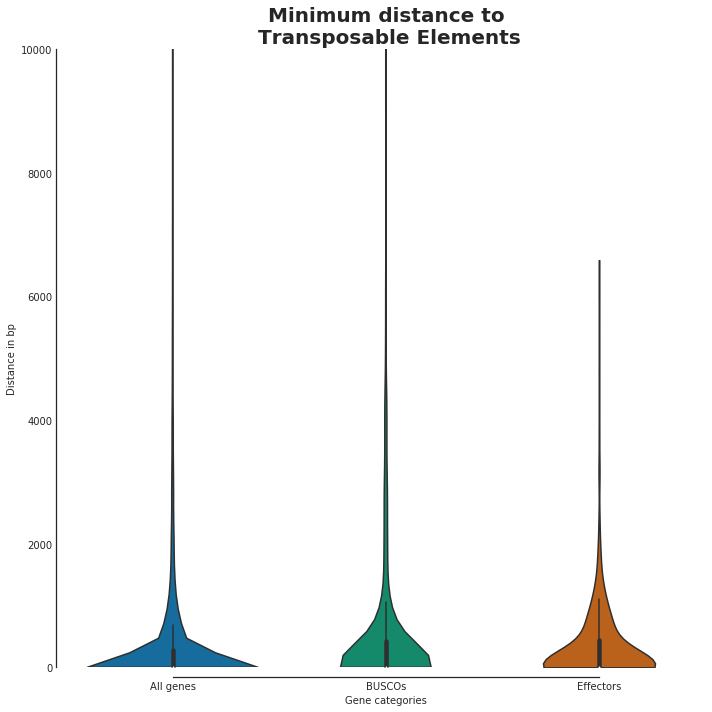

In [101]:
from matplotlib.font_manager import FontProperties
df = TE_dist_df.iloc[:,[0,1,2]].melt()
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot(y="value", x="variable", data=df, cut=0, 
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(y="value", x="variable", data=df,
 #           size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 10000)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance to Transposable Elements'
plt.title(title.replace('to', 'to\n'), fontproperties=font)
plt.xlabel("Gene categories")
plt.ylabel('Distance in bp')
#add the stats to it as well with numbers and lines
#ax.text(0.15, 59000, 'p~1.02e-34', color='k')
#ax.plot([-0.1, 1.1], [58000, 58000],color ='k' ,lw=1)
#ax.text(1.25, 56000, 'p~2.56e-21', color='k')
#ax.plot([0.1, 2.1], [55000, 55000],color ='k' ,lw=1)
#ax.text(1.25, 46000, 'p~0.22', color='k')
#ax.plot([0.9, 2.1], [45000, 45000],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)

#save the file as well
out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

This was to look at if subsetting the number of genes to the number of BUSCOs would change the analysis.

In [102]:
sub_set = len(p_effector_bed)

In [113]:
#get the distances of TEs to different gene categories
min_dist_TE_to_e = p_effector_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_b = p_busco_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_noe = p_noeffector_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,18].dropna().values
min_dist_TE_to_nob = p_non_busco_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values
min_dist_TE_to_g = p_gene_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values
min_dist_TE_to_noeb = p_no_eb_bed.random_subset(sub_set).closest(p_repeats_bed,d=True,t='last')\
                    .to_dataframe().iloc[:,15].dropna().values
TE_dist_df = pd.concat([pd.Series(x) for x in [min_dist_TE_to_g, min_dist_TE_to_b,\
            min_dist_TE_to_e, min_dist_TE_to_nob, min_dist_TE_to_noe, min_dist_TE_to_noeb]], axis=1)
TE_dist_df.rename(columns=dict(zip(TE_dist_df.columns,\
        ['All genes', 'BUSCOs', 'Effectors', 'No BUSCOs', 'No effectors', 'No BUSCOs no effectors'])), inplace=True) 

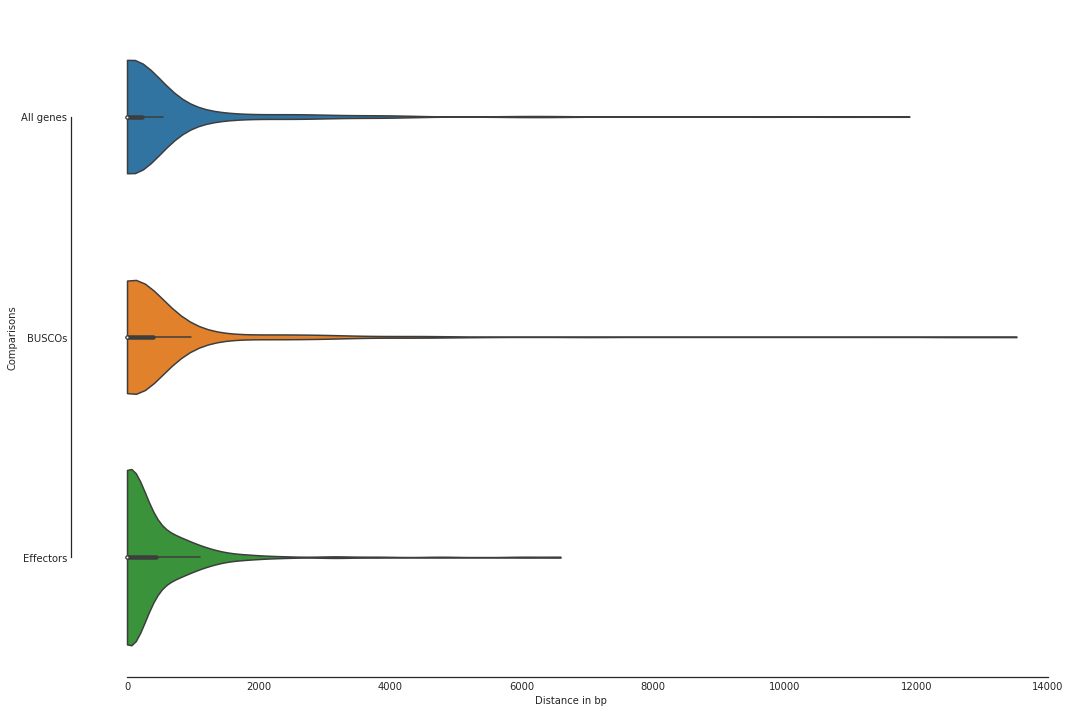

In [114]:
df = TE_dist_df.iloc[:,[0,1,2]].melt()
#do a boxplot and swarmplot on the same data
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x="value", y="variable", data=df,
 #             size=2, color=".3", linewidth=0)
#plt.xlim(0, 120000)
plt.ylabel("Comparisons")
plt.xlabel('Distance in bp')
#ax.text(118000, 0.5, '*\n*\n*', color='k')
#ax.plot([117000, 117000],[-0.1, 0.8], color ='k' )
#ax.text(118000, 2.5, '*\n*\n*', color='k')
#ax.plot([117000, 117000],[1.9, 2.8], color ='k' )
sns.despine(offset=10, trim=True)

In [115]:
scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_e)

RanksumsResult(statistic=-2.2630470136598575, pvalue=0.023632791321001927)

In [116]:
scipy.stats.ranksums(min_dist_TE_to_b, min_dist_TE_to_e)

RanksumsResult(statistic=-0.76612155804571402, pvalue=0.44360397674176533)

In [117]:
scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_b)

RanksumsResult(statistic=-1.5326959066103678, pvalue=0.12535079822934755)

In [118]:
_, p_TE_g_vs_e = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_e)
_, p_TE_g_vs_b = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_b)
_, p_TE_b_vs_e = scipy.stats.ranksums(min_dist_TE_to_b, min_dist_TE_to_e)
statsmodels.sandbox.stats.multicomp.multipletests([p_TE_g_vs_e, p_TE_g_vs_b, p_TE_b_vs_e],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

(array([False, False, False], dtype=bool),
 array([ 0.07089837,  0.37605239,  1.        ]),
 0.016952427508441503,
 0.016666666666666666)

Effectors closest Repeat
                18
count   308.000000
mean    352.811688
std     764.443403
min       0.000000
25%       0.000000
50%       0.000000
75%     444.500000
max    6589.000000


(0, 10000)

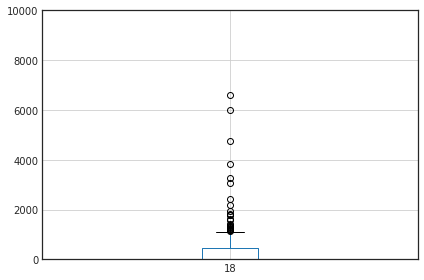

In [119]:
print('Effectors closest Repeat')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Repeat closest effector
                 18
count  1.151300e+05
mean   1.842615e+05
std    1.918132e+05
min    0.000000e+00
25%    5.006875e+04
50%    1.172065e+05
75%    2.537048e+05
max    1.012796e+06


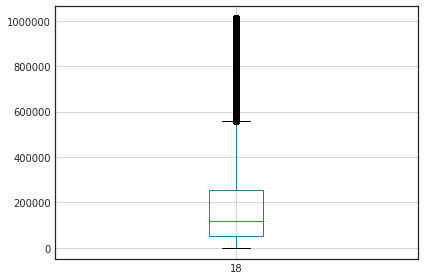

In [120]:
print('Repeat closest effector')
print(p_repeats_bed.closest(p_effector_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last').to_dataframe().boxplot(column=18)


BUSCO distance to closest repeat
                 18
count   1444.000000
mean     526.252078
std     1359.969345
min        0.000000
25%        0.000000
50%        0.000000
75%      425.500000
max    19085.000000


(0, 10000)

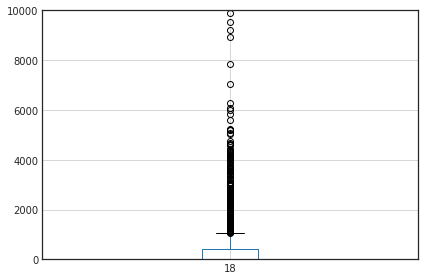

In [121]:
print('BUSCO distance to closest repeat')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

BUSCO distance to closest repeat
                  18
count  187187.000000
mean    40415.352220
std     45699.115544
min         0.000000
25%      9259.500000
50%     24624.000000
75%     54055.000000
max    347481.000000


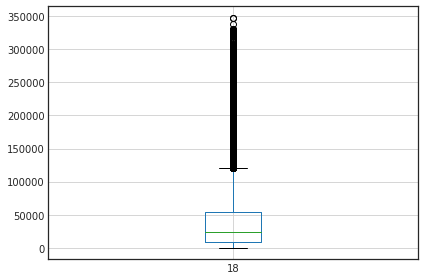

In [122]:
print('BUSCO distance to closest repeat')
print(p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().boxplot(column=18)


No Effector distance to closest repeat
                 18
count  14356.000000
mean     392.177138
std     1181.112756
min        0.000000
25%        0.000000
50%        0.000000
75%      227.000000
max    23286.000000


(0, 10000)

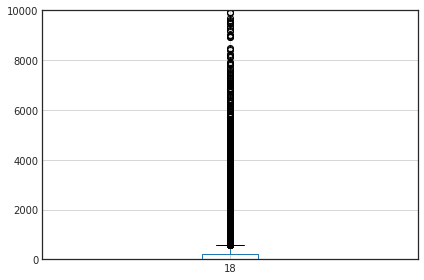

In [85]:
print('No Effector distance to closest repeat')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Relative distance from TE elements to other elements


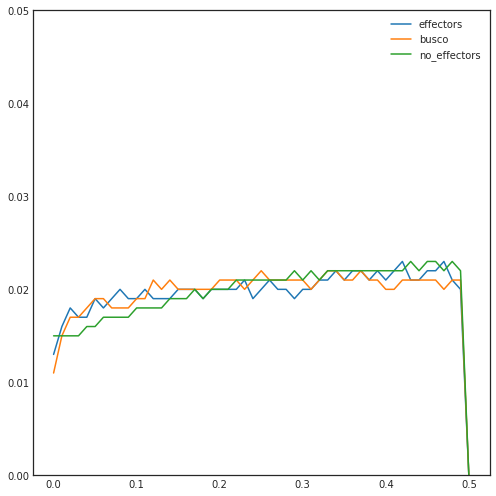

In [86]:
print('Relative distance from TE elements to other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

Relative distance of other elements to TEs


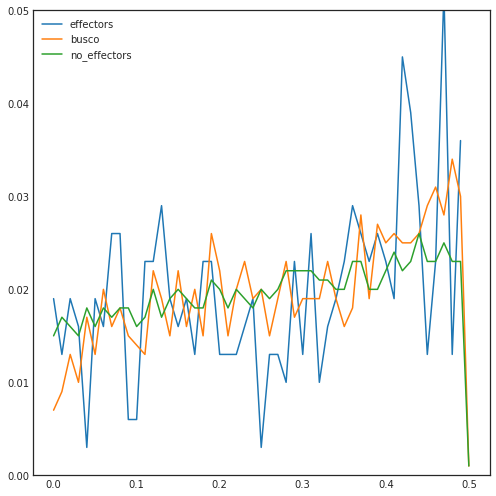

In [87]:
print('Relative distance of other elements to TEs')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

In [ ]:
#some stuff in the following lines

In [88]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_noeffector_bed)*100

17
ClassII:TIR:Tc1-Mariner       2.953469
ClassII:MITE:?                3.413207
ClassII:TIR:PIF-Harbinger     3.712733
ClassII:TIR:hAT               4.882976
ClassII:TIR:?                 5.029256
ClassI:LARD:?                 6.032321
ClassII:?:?                   9.933129
ClassI:LTR:Copia             10.796879
SSR                          18.668153
ClassI:LTR:Gypsy             22.694344
Name: 0, dtype: float64

In [89]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_effector_bed)*100

17
ClassII:TIR:PIF-Harbinger     2.922078
ClassII:TIR:Tc1-Mariner       2.922078
ClassII:TIR:?                 4.220779
ClassI:LTR:?                  4.545455
ClassI:LARD:?                 6.818182
ClassII:MITE:?                7.142857
ClassI:LTR:Copia             11.688312
ClassII:?:?                  13.961039
ClassI:LTR:Gypsy             15.259740
SSR                          19.155844
Name: 0, dtype: float64

In [90]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_busco_bed)*100

17
ClassI:LTR:?                  2.354571
ClassII:TIR:PIF-Harbinger     3.601108
ClassII:TIR:hAT               4.293629
ClassII:MITE:?                4.362881
ClassII:TIR:?                 6.855956
ClassI:LARD:?                 7.548476
ClassI:LTR:Copia              9.833795
ClassII:?:?                  11.980609
ClassI:LTR:Gypsy             17.243767
SSR                          21.675900
Name: 0, dtype: float64

In [91]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:Tc1-Mariner     728.129032
ClassI:LARD:?               782.232558
ClassI:?:?                  818.250000
ClassII:?:?                 880.280303
ClassII:Maverick:?          921.166667
ClassII:TIR:MuDR            943.761905
ClassII:Helitron:?         1127.153846
noCat                      1189.700000
ClassII:TIR:?              1228.925926
ClassII:MITE:?             1249.734694
Name: 18, dtype: float64

In [ ]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

In [ ]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

In [123]:
#now lookine at ClassII:?:? specifically
tmp_REPET[(tmp_REPET.distance > 400)&(tmp_REPET.attributes == 'ClassII:?:?')].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)
p_repeats_bed = BedTool(tmp_fn)

In [124]:
#test if effectors are closer to TEs than BUSCOS this case only ClassII:?:? TEs
stats.ranksums(
p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18].dropna().values,
p_busco_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18].dropna().values)

RanksumsResult(statistic=-1.8831816294156467, pvalue=0.05967575774667163)

In [ ]:
p_gene_bed = BedTool(p_gene_bed_fn)
p_no_eb_bed = BedTool(p_noeffector_nobusco_bed_fn)

In [125]:
#now get if effectors are closer to TEs than all genes using ClassII:?:? TEs
stats.ranksums(
p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18].dropna().values,
p_gene_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,15].dropna().values)

RanksumsResult(statistic=-1.9846679815211439, pvalue=0.04718142337003306)

In [ ]:
#now get if effectors are closer to TEs than all genes using ClassII:?:? TEs
stats.ranksums(
p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18].dropna().values,
p_no_eb_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,15].dropna().values)

In [ ]:
print('Effectors and there closest ClassII:?:? elements')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

In [ ]:
print('ClassII:?:? elements and there closest Effectors ')
print(p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

In [ ]:
print('Relative distance from ClassII:?:? elements and other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

In [ ]:
print('Relative distance of other elements to ClassII:?:?')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

In [ ]:
print('BUSCOs distance to closest ClassII:?:?')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

In [ ]:
print('No effectors distance to closest ClassII:?:?')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

In [ ]:
print('No effectors distance to closest ClassII:?:? while allowing for overlaps')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)

In [ ]:
#look at if effectors and buscos are linked or further apart using the redist function
print('Relative distance of between BUSCOS and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_busco_bed)['reldist'], p_effector_bed.reldist(p_busco_bed)['fraction'], label ='Effectors vs. BUSCO')
plt.plot(p_busco_bed.reldist(p_effector_bed)['reldist'], p_busco_bed.reldist(p_effector_bed)['fraction'], label= 'BUSCO vs effectors')

plt.ylim(0, 0.05)
plt.legend()

In [ ]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_noeffector_bed)['reldist'], p_effector_bed.reldist(p_noeffector_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_noeffector_bed.reldist(p_effector_bed)['reldist'], p_noeffector_bed.reldist(p_effector_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

In [ ]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_busco_bed.reldist(p_non_busco_bed)['reldist'], p_busco_bed.reldist(p_non_busco_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_non_busco_bed.reldist(p_busco_bed)['reldist'], p_non_busco_bed.reldist(p_busco_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

[]

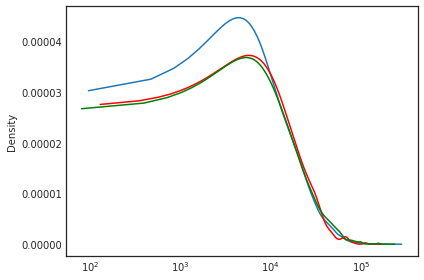

In [126]:
#densities without overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [ ]:
#densities with overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [ ]:
#define repeats
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [ ]:
#summary of closest TEs not allowing for overlaps 
#####Needs fixing for genes that don't have a nearest neighbou######
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

In [ ]:
#summary of closest TEs allowing for overlaps
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

Add some sub_sets for randommization to get equal sized groups

In [ ]:
#set the size of the subset here
sub_set = len(p_busco_bed)

In [127]:
p_effector_bed = BedTool(p_cluster_8_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

In [ ]:
#get some randomly subsampled beds of non_busco_non_effectors
p_non_busco_non_effector_bed = BedTool(p_noeffector_nobusco_bed_fn)
p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
for n in range(0,10):
    fn_n = p_noeffector_nobusco_bed_fn.replace('.gene.bed', '.randsub_%s.gene.bed'%n)
    p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
    p_no_b_no_e_rand_sub.to_dataframe().to_csv(fn_n, sep='\t', header=None, index=None)


count       290.000000
mean      97968.610345
std      135303.650706
min        1314.000000
25%       12738.000000
50%       41225.000000
75%      146234.750000
max      964418.000000
Name: Effectors, dtype: float64


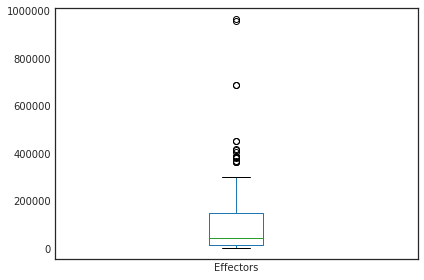

In [128]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1]
p_eself.name = 'Effectors'
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1]
print(p_eself.describe())
p_eself.plot(kind='box')

count    2.770000e+02
mean     1.404963e+05
std      1.802443e+05
min      1.087000e+03
25%      3.038400e+04
50%      7.530700e+04
75%      1.904880e+05
max      1.165173e+06
Name: All_genes, dtype: float64


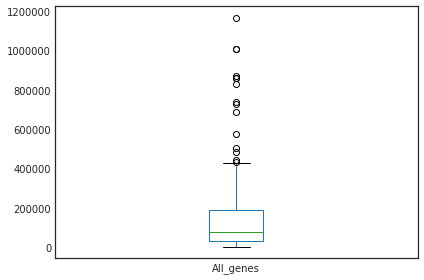

In [129]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
p_allall.name = 'All_genes'
print(p_allall.describe())
p_allall.plot(kind='box')

count    2.810000e+02
mean     1.355506e+05
std      1.730181e+05
min      4.540000e+02
25%      2.600200e+04
50%      8.319400e+04
75%      1.715030e+05
max      1.093236e+06
Name: BUSCO, dtype: float64


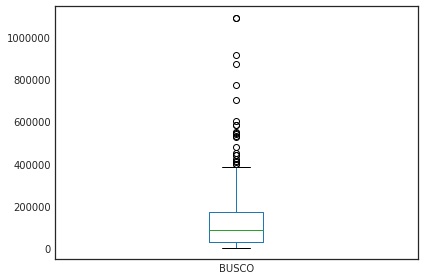

In [130]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
p_bself.name = 'BUSCO'
print(p_bself.describe())
p_bself.plot(kind='box')

count    2.800000e+02
mean     1.327454e+05
std      1.512169e+05
min      5.160000e+02
25%      3.225800e+04
50%      8.548100e+04
75%      1.790112e+05
max      1.253544e+06
Name: No_effectors, dtype: float64


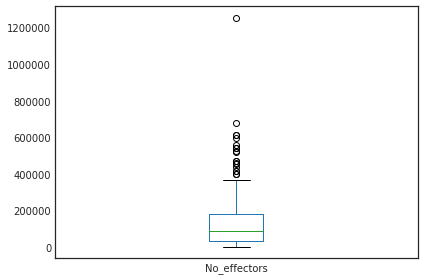

In [131]:
#non_effectors
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself = p_neself[p_neself > -1]
p_neself.name = 'No_effectors'
print(p_neself.describe())
p_neself.plot(kind='box')

Look if effectors and BUSCOs are actually linked
The question is if effectors are close to buscos than other genes. So do busco and effectors link together.

-> are busco more likely closest genes to effectors and vice versa
-> are the distance between busco and random genes larger than busco and effectors

effectors distance to closest Busco


count       291.000000
mean      98531.481100
std      114821.879876
min         670.000000
25%       17840.000000
50%       61532.000000
75%      131157.500000
max      646456.000000
Name: Closest Busco to effector, dtype: float64

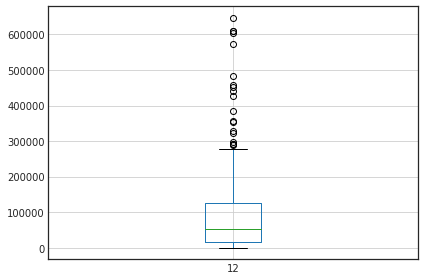

In [132]:
print('effectors distance to closest Busco')
p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_busco_c_df = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_busco_c_df = effector_busco_c_df[effector_busco_c_df>-1]
effector_busco_c_df.name = "Closest Busco to effector"
effector_busco_c_df.describe()

Closest effector to busco


count    2.850000e+02
mean     1.276959e+05
std      1.670630e+05
min      6.700000e+02
25%      1.946200e+04
50%      7.105900e+04
75%      1.600890e+05
max      1.113891e+06
Name: Closest effector to busco, dtype: float64

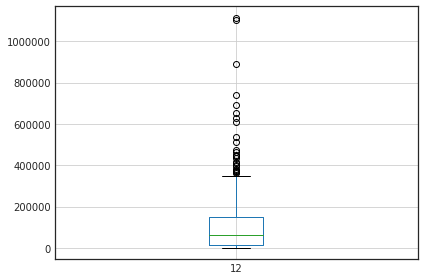

In [133]:
print('Closest effector to busco')
p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_effector_c_df = p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_effector_c_df = busco_effector_c_df[busco_effector_c_df>-1]
busco_effector_c_df.name = 'Closest effector to busco'
busco_effector_c_df.describe()

effectors distance to closest rand


count       290.000000
mean     142806.893103
std      147667.913182
min        1060.000000
25%       36817.250000
50%       98202.000000
75%      208632.750000
max      943380.000000
Name: Closest randsubset to effector, dtype: float64

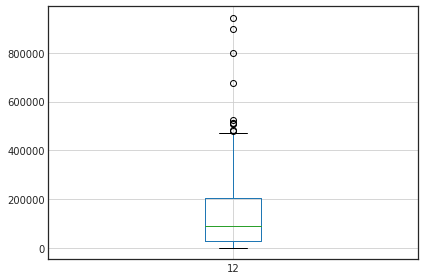

In [134]:
print('effectors distance to closest rand')
p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_randsubset_c_df = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_randsubset_c_df = effector_randsubset_c_df[effector_randsubset_c_df>-1]
effector_randsubset_c_df.name =  "Closest randsubset to effector"
effector_randsubset_c_df.describe()

busco distance to closest rand


count       286.000000
mean     145057.038462
std      149900.774441
min         519.000000
25%       46757.750000
50%       90920.000000
75%      207140.500000
max      912094.000000
Name: Closest rand sub to BUSCO, dtype: float64

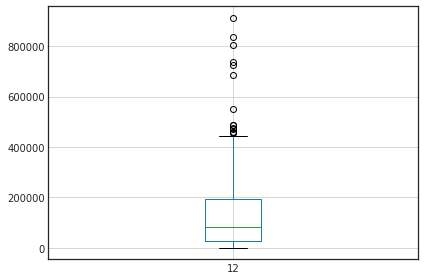

In [135]:
print('busco distance to closest rand')
p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_rand_sub_c_df = p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_rand_sub_c_df = busco_rand_sub_c_df[busco_rand_sub_c_df>-1]
busco_rand_sub_c_df.name = "Closest rand sub to BUSCO"
busco_rand_sub_c_df.describe()

rand to closest busco


count       282.000000
mean     144280.943262
std      134477.883736
min         519.000000
25%       43848.500000
50%      105537.000000
75%      206643.250000
max      613753.000000
Name: Closest BUSCO to rand subset, dtype: float64

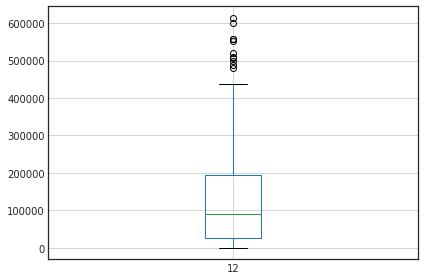

In [136]:
print('rand to closest busco')
p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_sub_busco_c_df = p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_sub_busco_c_df = rand_sub_busco_c_df[rand_sub_busco_c_df>-1]
rand_sub_busco_c_df.name = 'Closest BUSCO to rand subset'
rand_sub_busco_c_df.describe()

Rand to closest effector


count    2.850000e+02
mean     1.611356e+05
std      1.777969e+05
min      1.060000e+03
25%      4.187500e+04
50%      1.038690e+05
75%      2.190100e+05
max      1.028817e+06
Name: Closest effector to rand subset, dtype: float64

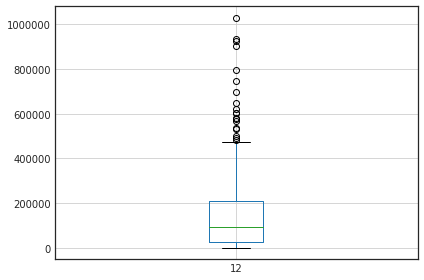

In [137]:
print('Rand to closest effector')
p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_subset_effector_c_df = p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_subset_effector_c_df = rand_subset_effector_c_df[rand_subset_effector_c_df>-1]
rand_subset_effector_c_df.name ='Closest effector to rand subset'
rand_subset_effector_c_df.describe()

In [138]:
#all against others both ways to see if effectors are closer to buscos compared to random subset
all_vs_others_c_df = \
 pd.concat([busco_effector_c_df,rand_subset_effector_c_df,effector_busco_c_df,rand_sub_busco_c_df,  \
             effector_randsubset_c_df, busco_rand_sub_c_df ], axis=1)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

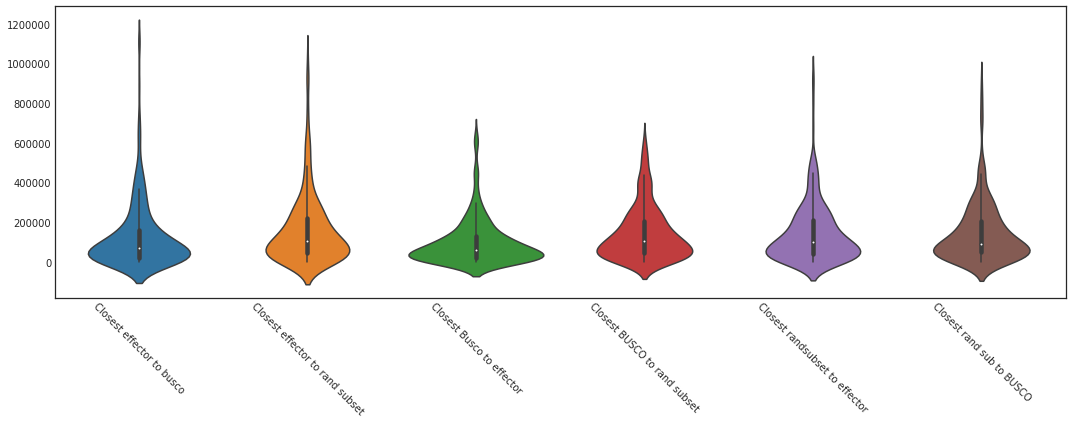

In [139]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_c_df)
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

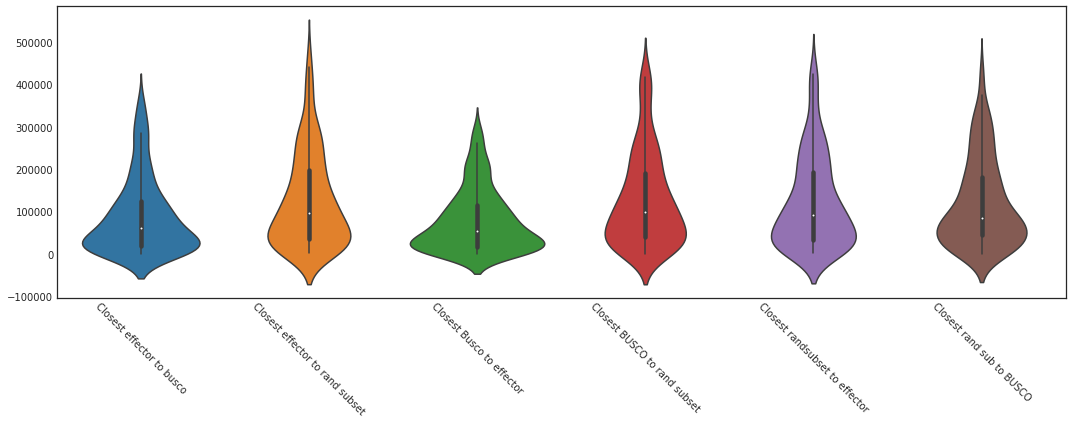

In [140]:
#plot the violine plots for distances once teh iqr is present only
all_vs_others_iqr_df = quant_cut_df(all_vs_others_c_df)
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_iqr_df)
plt.xticks(rotation=-45)

In [143]:
len(all_vs_others_c_df['Closest Busco to effector'])

306

In [141]:
#do some stats on it look first into ranksum test
scipy.stats.ranksums(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'])

RanksumsResult(statistic=-2.9393317614669994, pvalue=0.0032892078676808006)

In [142]:
scipy.stats.ranksums(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'])

RanksumsResult(statistic=-4.9966582389844234, pvalue=5.8332312566285116e-07)

In [144]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=35890.0, pvalue=5.8401415605292149e-07)

In [145]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=40389.5, pvalue=0.0032916318475438486)

In [146]:
new_c_names = ['Effectors -> BUSCOs', 'Effectors -> All genes subset','BUSCOs -> Effectors',\
               'BUSCOs -> All genes subset' ]

In [147]:
all_vs_others_iqr_df.rename(columns=dict(zip(all_vs_others_iqr_df.columns[:4],new_c_names)), inplace=True)

In [148]:
all_vs_others_iqr_melt = all_vs_others_iqr_df.melt()

In [149]:
all_vs_others_iqr_df.columns

Index(['Effectors -> BUSCOs', 'Effectors -> All genes subset',
       'BUSCOs -> Effectors', 'BUSCOs -> All genes subset',
       'Closest randsubset to effector', 'Closest rand sub to BUSCO'],
      dtype='object')

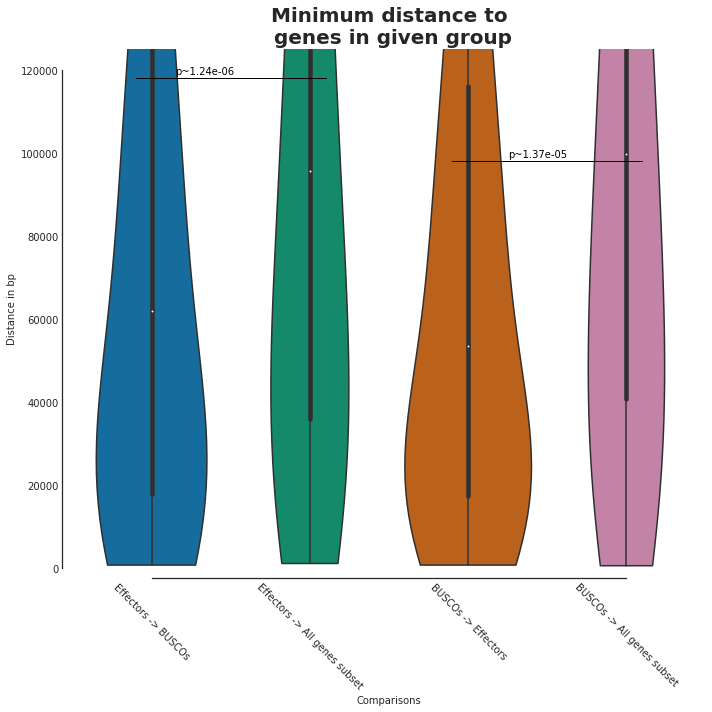

In [150]:

df = all_vs_others_iqr_melt\
    [all_vs_others_iqr_melt.variable.isin(all_vs_others_iqr_df.iloc[:,[0,1,2,3]].columns)].copy()
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot(y="value", x="variable", data=df, cut=0,
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(y="value", x="variable", data=df,
 #             size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 125000)
#plt.tight_layout()

#add the title and legends
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance to genes in given group'
plt.title(title.replace('to', 'to\n'), fontproperties=font)
plt.xlabel("Comparisons")
plt.ylabel('Distance in bp')

#add the stats to it as well with numbers and lines
ax.text(0.15, 119000, 'p~1.24e-06', color='k')
ax.plot([-0.1, 1.1], [118000, 118000],color ='k' ,lw=1)
ax.text(2.25, 99000, 'p~1.37e-05', color='k')
ax.plot([1.9, 3.1], [98000, 98000],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=-45)
#save the file as well
out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

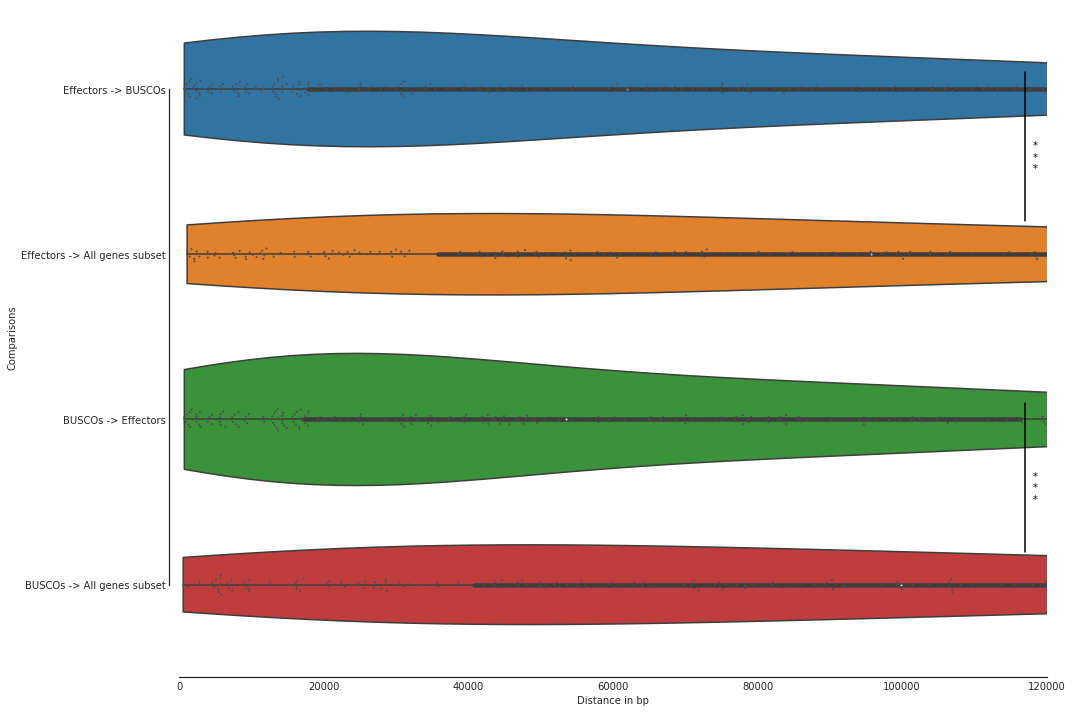

In [152]:
df = all_vs_others_iqr_melt\
    [all_vs_others_iqr_melt.variable.isin(all_vs_others_iqr_df.iloc[:,[0,1,2,3]].columns)].copy()
#do a boxplot and swarmplot on the same data
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
sns.swarmplot(x="value", y="variable", data=df,
              size=2, color=".3", linewidth=0)
plt.xlim(0, 120000)
plt.ylabel("Comparisons")
plt.xlabel('Distance in bp')
ax.text(118000, 0.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[-0.1, 0.8], color ='k' )
ax.text(118000, 2.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[1.9, 2.8], color ='k' )
sns.despine(offset=10, trim=True)

In [ ]:
#do a boxplot on the same data using own bining
bins = [x for x in range(0, int(all_vs_others_iqr_df.max().max())+10000,2000 )]
all_vs_others_iqr_melt['bins'] = pd.cut(all_vs_others_iqr_melt.value, bins)
all_vs_others_iqr_hist = all_vs_others_iqr_melt.groupby(by=['variable', 'bins']).count().unstack().T

In [ ]:
all_vs_others_iqr_hist['bins'] = all_vs_others_iqr_hist.index.get_level_values(1)

all_vs_others_iqr_hist['bins_left'] = all_vs_others_iqr_hist['bins'].apply(lambda x: x.left)

In [153]:
df = all_vs_others_iqr_hist.copy()
_max = all_vs_others_iqr_df.max().max()
fig, ax = plt.subplots(2,2, figsize=(10,15), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=1000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)

NameError: name 'all_vs_others_iqr_hist' is not defined

In [ ]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest Busco to effector'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest BUSCO to rand subset']

In [ ]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to busco'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to rand subset']

In [ ]:
#do a boxplot bin the data into same intervals for all and make new data frame out of it
all_vs_others_c_df_melt = all_vs_others_c_df.melt()
bins = [x for x in range(0, int(all_vs_others_c_df_melt.value.max())+10000,2000 )]
all_vs_others_c_df_melt['bins'] = pd.cut(all_vs_others_c_df_melt.value, bins)
all_vs_others_c_df_hist = all_vs_others_c_df_melt.groupby(by=['variable', 'bins']).count().unstack().T
all_vs_others_c_df_hist['bins'] = all_vs_others_c_df_hist.index.get_level_values(1)
all_vs_others_c_df_hist['bins_left'] = all_vs_others_c_df_hist['bins'].apply(lambda x: x.left)


In [ ]:
df = all_vs_others_c_df_hist.copy()
_max = all_vs_others_c_df_melt.value.max()
fig, ax = plt.subplots(2,2, figsize=(10,12), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=2000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)
#all_vs_others_iqr_df.hist(bins=30, figsize=(15,10), sharey='All', sharex="All")

cat Pst_104E_v12_ph_ctg.no_alleles_postQC.txt | xargs -I {} grep "{}" ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.list > ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.noalleles.list

In [ ]:
#check if effectors without alleles look any different.
orphan_effectors_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_Cluster8_UnderDiversifyingSelection.list')\
                                   , sep='\t', header=None)[0].tolist()

In [ ]:
effector_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_effector.list')\
                                   , sep='\t', header=None)[0].tolist()
busco_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_busco.list')\
                                   , sep='\t', header=None)[0].tolist()

In [ ]:
count = 0
for x in effector_list:
    if x in busco_list:
        count = count +1
print(count)

In [ ]:
len(set(effector_list) -set(busco_list))

In [ ]:
test_df  = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe()

In [ ]:
test_df[test_df[3].str.replace('TU', 'model').isin(orphan_effectors_list)].loc[:,12].describe()

In [ ]:
test_df.loc[:,12].describe()

No look a bit more into the distribution of the nearest neighbour distance

In [154]:
import seaborn as sns

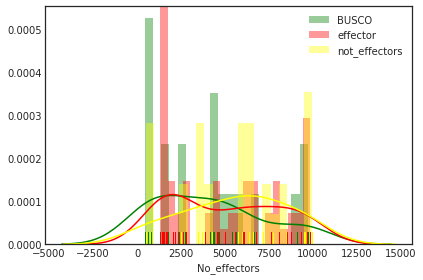

In [155]:
sns.distplot(p_bself[p_bself < 10000], bins=20, rug = True, color='g',label='BUSCO')
sns.distplot(p_eself[p_eself < 10000], bins=20, rug = True, color='red',label = 'effector')
sns.distplot(p_neself[p_neself <10000], bins=20, rug=True, color='yellow', label ='not_effectors')
plt.legend()

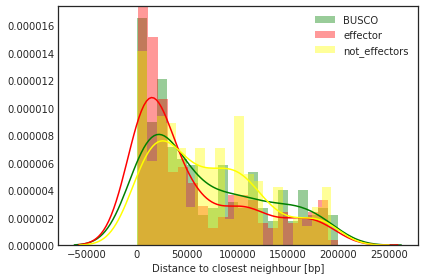

In [156]:
sns.distplot(p_bself[p_bself < 200000], bins=20, color='g' ,label='BUSCO')
sns.distplot(p_eself[p_eself < 200000], bins=20,  color='red',label = 'effector')
sns.distplot(p_neself[p_neself <200000], bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

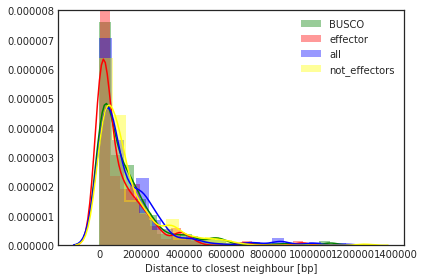

In [157]:
sns.distplot(p_bself, bins=20,color='g',  label='BUSCO')
sns.distplot(p_eself, bins=20,  color='red',label = 'effector')
sns.distplot(p_allall, bins=20,  color='b',label = 'all')
sns.distplot(p_neself, bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [158]:
#now make a nearest neightbour dataframe
nn_df = pd.concat([p_allall, p_bself, p_eself], names=['All genes', 'BUSCOs', 'Effectors'], axis=1)

In [159]:
import statsmodels.sandbox.stats.multicomp

In [160]:
_, p_ab = scipy.stats.ranksums(p_allall, p_bself)
_, p_ae = scipy.stats.ranksums(p_allall, p_eself)
_, p_be = scipy.stats.ranksums(p_bself, p_eself)

print(statsmodels.sandbox.stats.multicomp.multipletests([p_ab,p_ae, p_be],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))

(array([False,  True,  True], dtype=bool), array([  1.00000000e+00,   2.24335649e-05,   1.60301100e-03]), 0.016952427508441503, 0.016666666666666666)


In [ ]:
#NOW FILTER BY QUANTIELS

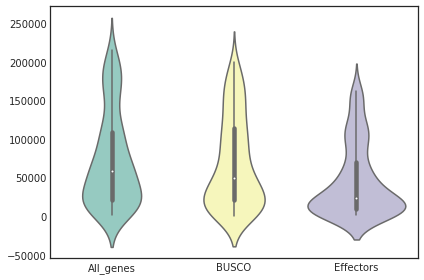

In [161]:
low = 0
high = 0.8
quant_df = nn_df.quantile([low,high])

qfilt_nn_df = nn_df.apply(lambda x: x[(x > quant_df.loc[low, x.name]) & (x  < quant_df.loc[high, x.name])], axis=0)

sns.violinplot(data=qfilt_nn_df , palette="Set3")

#now do stats on dataset, filter on IQR and plot the filtered data for paper

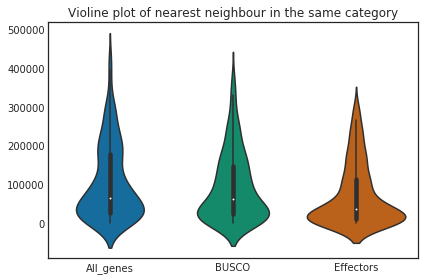

In [162]:
iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_low.name ='low'
iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_high.name = 'high'

iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
plt.title('Violine plot of nearest neighbour in the same category')
sns.violinplot(data=iqr_nn_df  , palette=sns.color_palette('colorblind'))

In [163]:
_, p_ab = scipy.stats.ranksums(p_allall, p_bself)
_, p_ae = scipy.stats.ranksums(p_allall, p_eself)
_, p_be = scipy.stats.ranksums(p_bself, p_eself)

print(statsmodels.sandbox.stats.multicomp.multipletests([p_ab,p_ae, p_be],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))

(array([False,  True,  True], dtype=bool), array([  1.00000000e+00,   2.24335649e-05,   1.60301100e-03]), 0.016952427508441503, 0.016666666666666666)


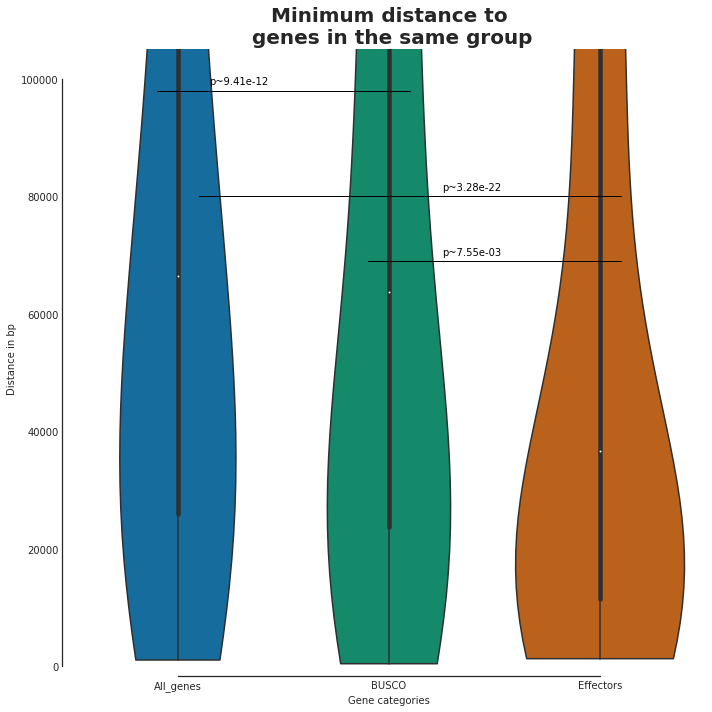

In [164]:
from matplotlib.font_manager import FontProperties
#change df here
df = iqr_nn_df

#set style
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot( data=df, cut=0, 
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot( data=df,
            #size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 105000)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance to genes in the same group'
plt.title(title.replace('to', 'to\n'), fontproperties=font)
plt.xlabel("Gene categories")
plt.ylabel('Distance in bp')
#add the stats to it as well with numbers and lines
ax.text(0.15, 99000, 'p~9.41e-12', color='k')
ax.plot([-0.1, 1.1], [98000, 98000],color ='k' ,lw=1)
ax.text(1.25, 81000, 'p~3.28e-22', color='k')
ax.plot([0.1, 2.1], [80000, 80000],color ='k' ,lw=1)
ax.text(1.25, 70000, 'p~7.55e-03', color='k')
ax.plot([0.9, 2.1], [69000, 69000],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)
sns.set_style("white")
#save the file as well
out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

57 104 43 46


(0, 20000)

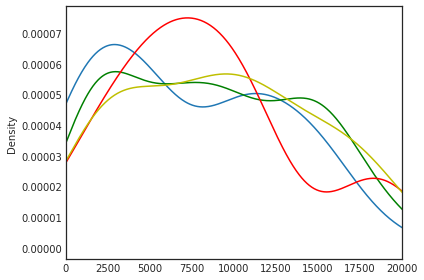

In [165]:
p_bself[p_bself < 20000].plot(kind='density')
p_eself[p_eself < 20000].plot(kind='density', color='g')
p_neself[p_neself < 20000].plot(kind='density', color='r')
p_eall[p_eall < 20000].plot(kind='density', color='y')
#plt.semilogx()
print(len(p_bself[p_bself < 20000]), len(p_eself[p_eself < 20000]), len(p_neself[p_neself < 20000]), len(p_eall[p_eall < 20000]))
plt.xlim(0, 20000)

In [ ]:
p_eall[p_eall].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_eself[p_eself].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_bself[p_bself ].plot(kind='hist', bins=20,normed=True)
plt.ylim(0, 0.00020)

In [ ]:
p_neself[p_neself ].plot(kind='hist',bins=20,normed=True)
plt.ylim(0, 0.00020)

It seems like there seems to be no clear link between effector candidates and closest neighbour in terms of TEs in general. They all have the same distance in general.
Maybe Gypsy and ClassII:?:? should be looked at more carefully. Those are depleted and enriched in busco and effector genes. In general there seems to be a trend towards ClassII elements compared to ClassI in effector candidates.
This changes when for allowing for overlaps.

It seems that effectors are closer together than noneffector genes. Buscos also seem to cluster a bit. Let's see if we can visualize the location of genes on certain contigs vs repeats and such.

In [ ]:
#start with getting effectors per contig divided by length divded by # of overall genes

In [ ]:
#get effectors per contig
effector_bdf = pd.read_csv(p_effector_bed_fn, header=None, sep='\t')

In [ ]:
p_effectors_per_contig  = effector_bdf.groupby(0).count()[1]
p_effectors_per_contig.name = 'effectors'

In [ ]:
#get all others counts per contig
p_all_genes_per_contig = pd.read_csv(p_gene_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_all_genes_per_contig.name = 'all_genes'
p_noeffectors_per_contig = pd.read_csv(p_noeffector_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_noeffectors_per_contig.name = 'no_effectors'
p_busco_per_contig = pd.read_csv(p_busco_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_busco_per_contig.name = 'buscos'

In [ ]:
#read in the genome file that contains the length of each contig in the second column
p_contig_length = pd.read_csv(os.path.join(GFF_FOLDER, 'Pst_104E_v12_p_ctg.genome_file'), header = None,\
                          names=['contig' , 'length'], sep='\t').sort_values('contig')

In [ ]:
p_contig_length.index = p_contig_length.contig

p_contig_length = p_contig_length.loc[:, 'length']

gene_dis_per_contig = pd.concat([p_contig_length,p_all_genes_per_contig,p_noeffectors_per_contig,p_busco_per_contig,  p_effectors_per_contig ], axis = 1)

In [ ]:
from scipy.stats import chisquare

In [ ]:
#fill nan with 0s
gene_dis_per_contig.fillna(value=0, inplace=True)

In [ ]:
gene_dis_per_contig.effectors.sum()

In [ ]:
#chisquare for genes per contig vs bases per contig
chisquare(gene_dis_per_contig.length.values/gene_dis_per_contig.length.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
chisquare(gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
#calculate the % of each category that are on a specific contig
gene_dis_per_contig['%busco'] = gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum() *100
gene_dis_per_contig['%effector'] = gene_dis_per_contig.effectors.values/gene_dis_per_contig.effectors.sum() *100
gene_dis_per_contig['%all_genes'] = gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum() *100
gene_dis_per_contig['%no_effector'] = gene_dis_per_contig.no_effectors.values/gene_dis_per_contig.no_effectors.sum() *100

In [ ]:
#not sure why this isn't working
chisquare(gene_dis_per_contig['%effector'], f_exp = gene_dis_per_contig['%all_genes'])

In [ ]:
#have a look at the different percentages
gene_dis_per_contig.loc[:,['%effector', '%all_genes','%no_effector' ,'%busco']]

In [ ]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes']].index

In [ ]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes', '%busco']]

In [ ]:
#effectors per contig > than expected 1.5 increase?
gene_dis_per_contig[(gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes']) > 1.5].loc[:,['effectors', '%effector', 'all_genes','%all_genes']].index

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%all_genes'] > gene_dis_per_contig['%busco'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%busco'] > gene_dis_per_contig['%all_genes'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) & (gene_dis_per_contig['%busco'] > 0.5 )\
                    ].loc[:,['buscos', '%busco', '%all_genes']]

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) \
                    ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.1) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9) ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.0000001) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9999) ].sum()

In [ ]:
#enriched for effectors relative to busco and all genes. Seems to be the case that their might be contigs
#with less BUSCOs and more effectors
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%effector'] < 1) & \
                    (gene_dis_per_contig['%all_genes'] / gene_dis_per_contig['%effector'] < 1) ].sum()

Get closest features genes vs. TEs

In [ ]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start

tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'tmpsuperfamily.bed')
tmp_REPET[tmp_REPET.distance > 400].loc[:,['seqid', 'start', 'end', 'attributes', 'score', 'strand']].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [ ]:
tmp_df = p_effector_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of effectors having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))

print('Per of effectors having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))


In [ ]:
tmp_df = p_allgene_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of genes having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

print('Per of genes having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

Get 5 and 3 prime distances of genes

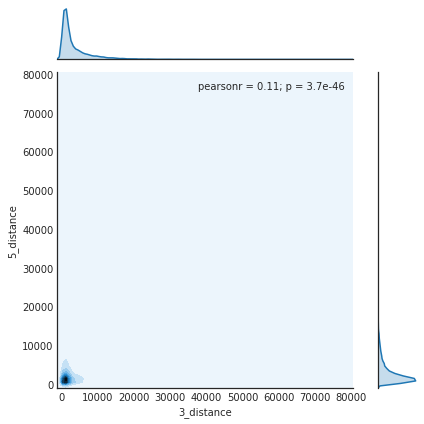

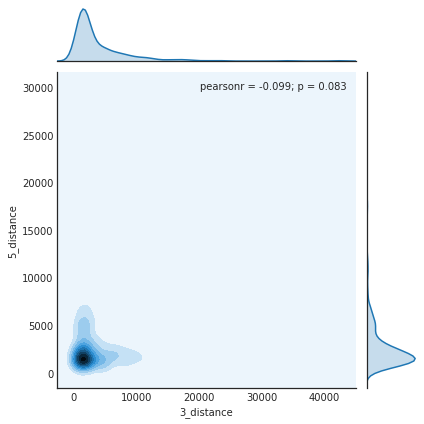

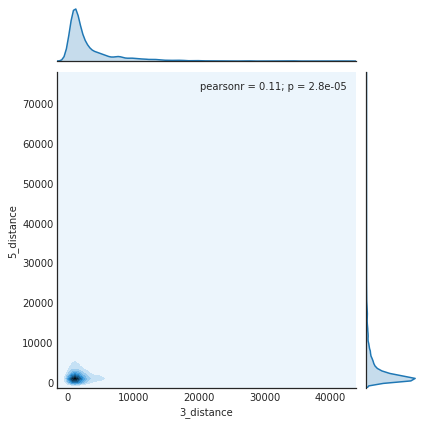

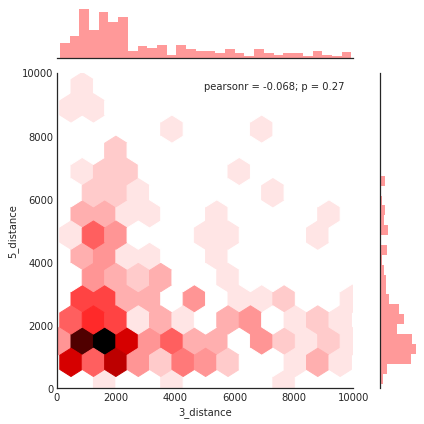

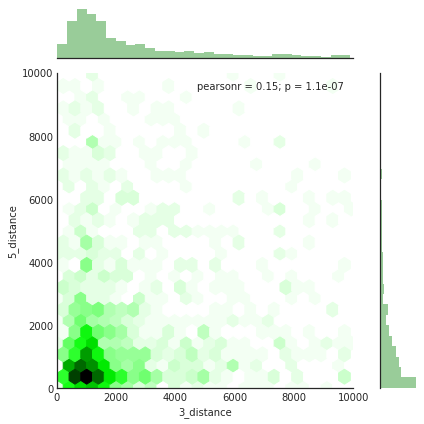

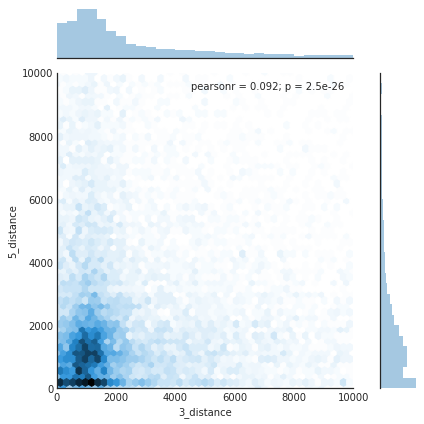

In [166]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
g_to_g_3 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]


g_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
g_to_g_5 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
g_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

g_to_g_merged = g_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 and at the 3' end drop everything that has a negative distance meaning no 3' neighbour

g_to_g_merged = g_to_g_merged[ (g_to_g_merged['5_target'] !='.') &(g_to_g_merged['3_target'] !='.') ]


g_to_g_merged['5_distance'] = abs(g_to_g_merged['5_distance'])
g_to_g_merged['5_distance_log10'] = np.log10(g_to_g_merged['5_distance'])
g_to_g_merged['3_distance_log10'] = np.log10(g_to_g_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde")



#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_g_3 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_g_5 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_g_merged = e_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_g_merged = e_to_g_merged[((e_to_g_merged['5_target'] != '.') & ((e_to_g_merged['3_target'] != '.'))) ]
e_to_g_merged['5_distance'] = abs(e_to_g_merged['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde")


#now for busco
b_to_g_3 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
b_to_g_5 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
b_to_g_merged = b_to_g_3.merge(b_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
b_to_g_merged = b_to_g_merged[((b_to_g_merged['5_target'] !='.') & (b_to_g_merged['3_target'] !='.')) ]
b_to_g_merged['5_distance'] = abs(b_to_g_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged, kind="kde")

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)


#subset everything by fixed numbers maybe to IQR or such in future
sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged[(e_to_g_merged['5_distance'] < 10000) &\
        (e_to_g_merged['3_distance'] < 10000)], kind="hex", color='r',xlim=[0,10000], ylim=[0,10000],\
             marginal_kws=dict(bins=30))


sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged[(b_to_g_merged['5_distance'] < 10000) &\
        (b_to_g_merged['3_distance'] < 10000)], kind="hex",color='g', xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged[(g_to_g_merged['5_distance'] < 10000) &\
        (g_to_g_merged['3_distance'] < 10000)], kind="hex", xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

Now look at the distance to the closest gene of the same group

In [ ]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

all_all_rand_3 = p_allall_rand_sub.closest( p_allall_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()


all_all_rand_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
all_all_rand_5 = p_allall_rand_sub.closest( p_allall_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
all_all_rand_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

all_all_rand_merged = all_all_rand_3.merge(all_all_rand_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 <- the .1 was no appropriate here as the random subsampling can lead
#to alternative first gene models selected on the respective contig
#extended the initial df of closest to include also queyr and target. Now filtering on no target ='.' possible

all_all_rand_merged = all_all_rand_merged[((all_all_rand_merged['5_target'] != '.')&(all_all_rand_merged['3_target'] != '.')  ) ]



all_all_rand_merged['5_distance'] = abs(all_all_rand_merged['5_distance'])
all_all_rand_merged['5_distance_log10'] = np.log10(all_all_rand_merged['5_distance'])
all_all_rand_merged['3_distance_log10'] = np.log10(all_all_rand_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=all_all_rand_merged, kind="kde")



In [ ]:

#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_e_sub_3 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()
e_to_e_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_e_sub_5 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
e_to_e_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_e_sub_merged = e_to_e_sub_3.merge(e_to_e_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_e_sub_merged = e_to_e_sub_merged [((e_to_e_sub_merged ['5_target'] != '.') & (e_to_e_sub_merged ['3_target'] != '.') )  ]
e_to_e_sub_merged ['5_distance'] = abs(e_to_e_sub_merged ['5_distance'])

#sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged , kind="kde", color='red')



In [ ]:

#now for busco
p_busco_bed_rand_sub_3 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_5 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_3.merge(p_busco_bed_rand_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_merged[((p_busco_bed_rand_sub_merged['5_target'] != '.') & (p_busco_bed_rand_sub_merged['5_target'] != '.') )]
p_busco_bed_rand_sub_merged['5_distance'] = abs(p_busco_bed_rand_sub_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged, kind="kde" ,color = 'green')

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)




In [ ]:
#now try to overlay some scatter plots with 
fig, ax = plt.subplots(figsize=(12,12))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(all_all_rand_merged['3_distance'], all_all_rand_merged['5_distance'],\
            cut=0, ax=ax,cbar=True, cmap='viridis_r', n_levels=60)

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12, 12))
ax.hexbin(all_all_rand_merged['3_distance'], all_all_rand_merged['5_distance'], gridsize=50\
        , cmap='viridis_r')
ax.scatter(e_to_e_sub_merged['3_distance'], e_to_e_sub_merged['5_distance'], color='w', alpha=0.3)

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12, 12))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 10000
df = g_to_g_merged
df2 = e_to_g_merged
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
hb = ax.hexbin(df['3_distance'], df['5_distance'], gridsize=50\
        , cmap='viridis_r')

ax.scatter(df2['3_distance'], df2['5_distance'],\
           color='r', marker='*', alpha=0.1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12, 12))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 50000000
df = g_to_g_merged
df2 = e_to_g_merged
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
hb = ax.hexbin(np.log10(df['3_distance']), np.log10(df['5_distance']), gridsize=100\
        ,marginals=True, cmap='viridis_r')

ax.scatter(np.log10(df2['3_distance']), np.log10(df2['5_distance']),\
           color='r', edgecolors='w', marker='o', alpha=0.1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(24, 8))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 50000000
df = e_to_g_merged
df2 = g_to_g_merged
df3= b_to_g_merged
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
df3 = df3[(df2['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[2].hexbin(df['3_distance'], df['5_distance'], xscale='log', yscale='log',\
                  gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 5, 0, 5])
hb1 = ax[0].hexbin(df2['3_distance'], df2['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 5, 0, 5])
hb2 = ax[1].hexbin(df3['3_distance'], df3['5_distance'], xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 5, 0, 5])

#ax.scatter(np.log10(df2['3_distance']), np.log10(df2['5_distance']),\
 #          color='r', edgecolors='w', marker='o', alpha=0.1)
cb = fig.colorbar(hb, ax=ax[2])
cb1 = fig.colorbar(hb1, ax=ax[0])
cb2 = fig.colorbar(hb2, ax=ax[1])

#set titels
#hb2.title.s set_label('BUSCOS')
#hb1.title.set_label('All genes')
#hb.title.set_label('Effector candidates')

cb.set_label('counts')
cb1.set_label('counts')
cb2.set_label('counts')

In [174]:
len(df3)

305

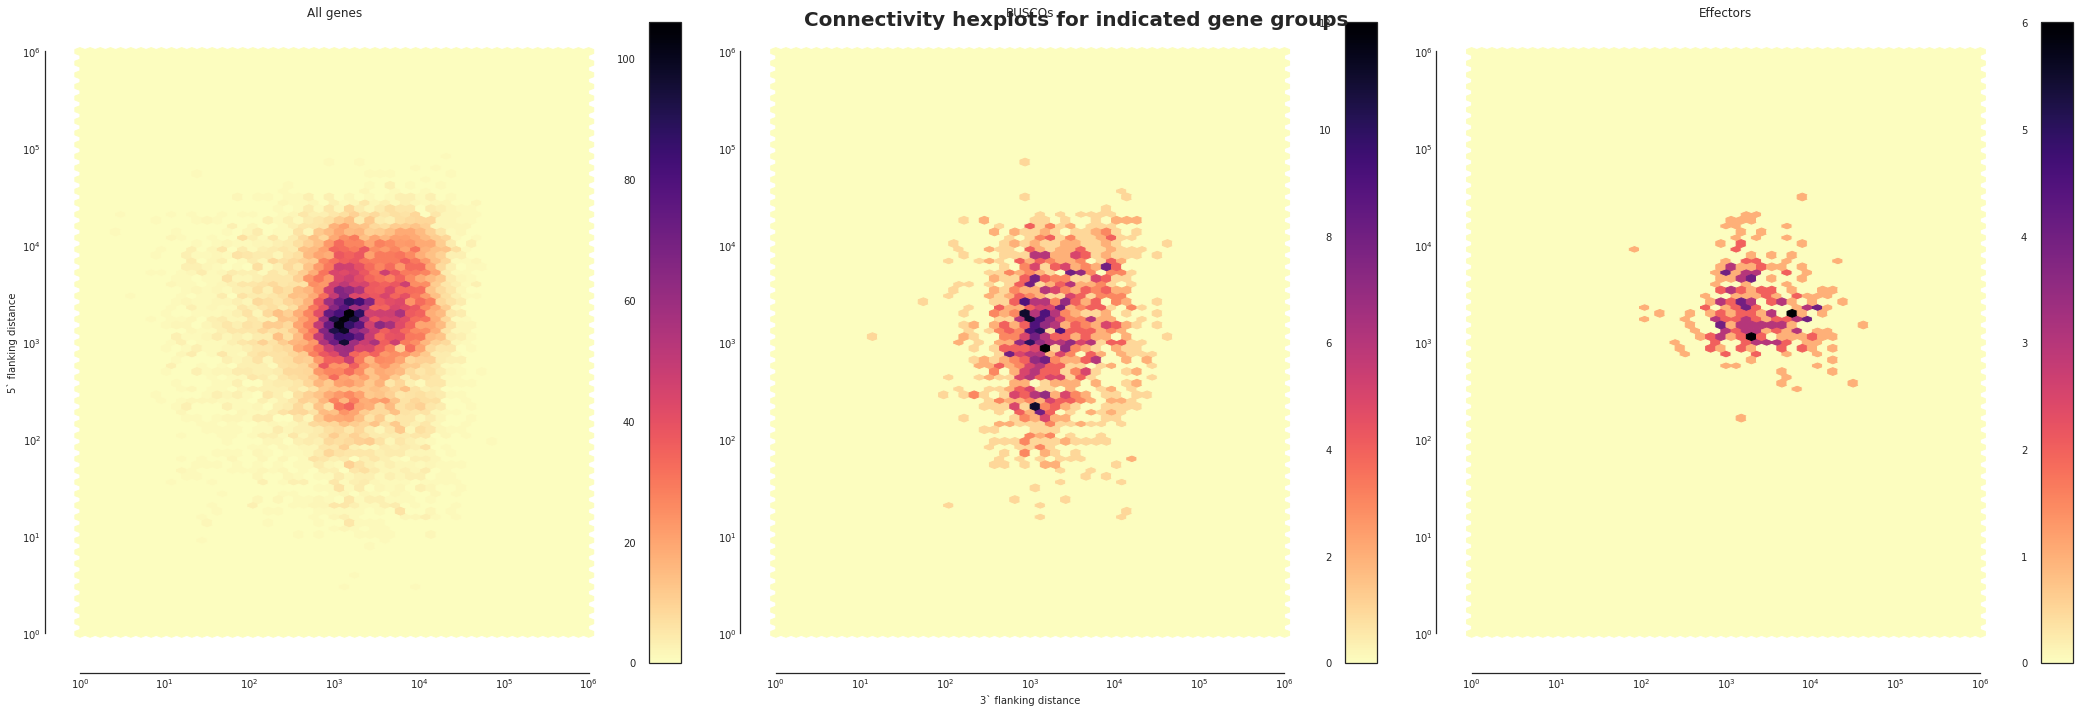

In [175]:
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(30, 10))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 10000000000
df = _5_to_3_df(p_gene_bed_fn, p_gene_bed_fn)
df2 = _5_to_3_df( p_cluster_8_bed_fn, p_gene_bed_fn)
df3= _5_to_3_df(p_busco_bed_fn,p_gene_bed_fn )
#df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
#df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
#df3 = df3[(df2['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[0].hexbin(df['3_distance'], df['5_distance'], xscale='log', yscale='log',\
                  gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])
hb1 = ax[2].hexbin(df2['3_distance'], df2['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])
hb2 = ax[1].hexbin(df3['3_distance'], df3['5_distance'], xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])

cb = fig.colorbar(hb, ax=ax[0])
cb1 = fig.colorbar(hb1, ax=ax[2])
cb2 = fig.colorbar(hb2, ax=ax[1])

# Set common labels
ax[1].set_xlabel('3` flanking distance')
ax[0].set_ylabel('5` flanking distance')

#set colorbar labels
sns.despine(offset=10, trim=True)
#cb.set_label('All gene')
#cb1.set_label('Effectors')
#cb2.set_label('BUSCOS')

#set subtitels
ax[1].set_title('BUSCOs')
ax[0].set_title('All genes')
ax[2].set_title('Effectors')

#set main title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)
title = 'Connectivity hexplots for indicated gene groups'
plt.suptitle(title, fontproperties=font)


out_file_name = "_".join(title.split(' '))
#fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from numpy import nan, inf

# Used to reconstruct the colormap in pycam02ucs.cm.viscm
parameters = {'xp': [22.674387857633945, -10.903679653679603, -27.867965367965326, -46.32034632034626, 9.9296536796537396, -1.2562144886363136],
              'yp': [-20.102530541012214, -39.58333333333333, -51.19047619047619, 60.714285714285694, 66.369047619047592, -0.46657986111111427],
              'min_Jp': 18.8671875,
              'max_Jp': 99.79166666666667}

cm_data = [[ 0.26700126,  0.00495011,  0.32938542],
       [ 0.2675047 ,  0.01376658,  0.3343288 ],
       [ 0.2679605 ,  0.02286997,  0.33927239],
       [ 0.26836956,  0.03225882,  0.34421742],
       [ 0.26873256,  0.04189182,  0.34916517],
       [ 0.2690482 ,  0.05088905,  0.35411805],
       [ 0.26931426,  0.05914864,  0.3590789 ],
       [ 0.2695349 ,  0.06684456,  0.36404617],
       [ 0.26970998,  0.07409699,  0.3690209 ],
       [ 0.26983912,  0.0809905 ,  0.37400407],
       [ 0.26992171,  0.08758726,  0.37899654],
       [ 0.26995164,  0.0939392 ,  0.38400248],
       [ 0.2699325 ,  0.10007857,  0.38901937],
       [ 0.26986343,  0.10603461,  0.39404728],
       [ 0.26974287,  0.11183159,  0.39908641],
       [ 0.26956895,  0.11748972,  0.4041367 ],
       [ 0.26933959,  0.12302608,  0.4091979 ],
       [ 0.2690524 ,  0.12845532,  0.41426944],
       [ 0.26870027,  0.13379302,  0.41935335],
       [ 0.26828484,  0.1390473 ,  0.42444552],
       [ 0.26780307,  0.14422811,  0.42954439],
       [ 0.26725159,  0.1493444 ,  0.43464803],
       [ 0.26662673,  0.15440432,  0.43975414],
       [ 0.26592462,  0.15941528,  0.44485997],
       [ 0.2651411 ,  0.16438411,  0.44996231],
       [ 0.26427178,  0.16931714,  0.45505746],
       [ 0.26331205,  0.17422025,  0.46014118],
       [ 0.26225707,  0.17909897,  0.46520868],
       [ 0.2611018 ,  0.18395845,  0.47025457],
       [ 0.25984104,  0.18880356,  0.47527285],
       [ 0.25846941,  0.19363888,  0.48025683],
       [ 0.25698144,  0.19846871,  0.48519917],
       [ 0.25537155,  0.2032971 ,  0.49009181],
       [ 0.25363416,  0.20812783,  0.49492596],
       [ 0.25176371,  0.21296439,  0.4996921 ],
       [ 0.24975472,  0.21781003,  0.50437997],
       [ 0.24760191,  0.22266767,  0.50897858],
       [ 0.24530027,  0.22753991,  0.51347624],
       [ 0.24284374,  0.23242953,  0.51786097],
       [ 0.24022209,  0.23734052,  0.52212099],
       [ 0.23743856,  0.24227187,  0.52624087],
       [ 0.23449065,  0.24722452,  0.53020665],
       [ 0.23137687,  0.2521989 ,  0.53400409],
       [ 0.22809698,  0.25719491,  0.53761892],
       [ 0.22464056,  0.26221563,  0.54103748],
       [ 0.22102136,  0.26725609,  0.54424467],
       [ 0.21724526,  0.27231401,  0.54722731],
       [ 0.21331753,  0.27738734,  0.54997311],
       [ 0.20924009,  0.28247511,  0.55247017],
       [ 0.20503611,  0.28756997,  0.55470963],
       [ 0.20072073,  0.29266742,  0.55668417],
       [ 0.19630451,  0.29776464,  0.55838707],
       [ 0.19181779,  0.30285342,  0.55981699],
       [ 0.18728483,  0.307928  ,  0.56097392],
       [ 0.18273029,  0.31298309,  0.56185975],
       [ 0.17818816,  0.31801151,  0.56248099],
       [ 0.17369001,  0.32300754,  0.56284549],
       [ 0.16927267,  0.3279648 ,  0.56296481],
       [ 0.16496903,  0.33287876,  0.56285061],
       [ 0.16081574,  0.33774455,  0.56251745],
       [ 0.15685394,  0.34255681,  0.56198367],
       [ 0.15311234,  0.34731386,  0.56126269],
       [ 0.14962488,  0.35201301,  0.56037146],
       [ 0.14643291,  0.35664987,  0.55933328],
       [ 0.14355505,  0.36122576,  0.55815918],
       [ 0.14101658,  0.36574007,  0.55686541],
       [ 0.1388437 ,  0.37019148,  0.5554716 ],
       [ 0.13705362,  0.37458028,  0.55399387],
       [ 0.13565242,  0.37890882,  0.5524419 ],
       [ 0.13464687,  0.38317834,  0.55082879],
       [ 0.13403854,  0.38739039,  0.54916668],
       [ 0.13382949,  0.3915451 ,  0.54747372],
       [ 0.13400503,  0.39564621,  0.54575352],
       [ 0.13455185,  0.3996961 ,  0.54401439],
       [ 0.13545357,  0.40369707,  0.54226438],
       [ 0.13669076,  0.40765151,  0.54051065],
       [ 0.13824169,  0.41156187,  0.5387595 ],
       [ 0.14008301,  0.41543063,  0.53701638],
       [ 0.14219109,  0.41925997,  0.53528783],
       [ 0.14454103,  0.42305246,  0.53357753],
       [ 0.14710775,  0.42681092,  0.53188664],
       [ 0.14986765,  0.43053777,  0.53021784],
       [ 0.15279807,  0.43423536,  0.52857323],
       [ 0.1558775 ,  0.43790601,  0.52695439],
       [ 0.1590858 ,  0.44155197,  0.52536241],
       [ 0.16240422,  0.44517543,  0.52379792],
       [ 0.16581552,  0.44877852,  0.52226112],
       [ 0.16930389,  0.45236328,  0.52075182],
       [ 0.17285498,  0.45593169,  0.51926948],
       [ 0.17645581,  0.45948567,  0.51781319],
       [ 0.18009472,  0.46302703,  0.51638174],
       [ 0.18376132,  0.46655752,  0.51497361],
       [ 0.18744638,  0.47007882,  0.51358698],
       [ 0.19114177,  0.47359253,  0.5122198 ],
       [ 0.1948404 ,  0.47710014,  0.51086974],
       [ 0.1985361 ,  0.48060303,  0.50953474],
       [ 0.20222358,  0.48410243,  0.50821324],
       [ 0.20589852,  0.48759977,  0.50690054],
       [ 0.20955735,  0.49109622,  0.50559341],
       [ 0.2131972 ,  0.49459285,  0.50428847],
       [ 0.21681592,  0.49809065,  0.50298215],
       [ 0.22041204,  0.50159052,  0.50167074],
       [ 0.22398469,  0.50509327,  0.50035038],
       [ 0.22753361,  0.50859958,  0.49901711],
       [ 0.23105913,  0.51211007,  0.49766684],
       [ 0.23456209,  0.51562526,  0.49629541],
       [ 0.23804381,  0.5191454 ,  0.49490005],
       [ 0.24150619,  0.52267089,  0.4934757 ],
       [ 0.2449516 ,  0.52620203,  0.49201705],
       [ 0.24838279,  0.52973892,  0.49051972],
       [ 0.25180295,  0.53328158,  0.48897932],
       [ 0.25521563,  0.53682992,  0.48739148],
       [ 0.25862476,  0.54038379,  0.48575188],
       [ 0.26203458,  0.54394289,  0.48405623],
       [ 0.2654496 ,  0.54750679,  0.48230139],
       [ 0.26887464,  0.55107513,  0.48048219],
       [ 0.27231474,  0.55464743,  0.47859409],
       [ 0.27577514,  0.55822308,  0.47663314],
       [ 0.2792612 ,  0.56180141,  0.47459547],
       [ 0.28277842,  0.56538168,  0.47247738],
       [ 0.2863324 ,  0.56896307,  0.47027525],
       [ 0.28992874,  0.57254474,  0.46798571],
       [ 0.29357314,  0.57612578,  0.46560498],
       [ 0.29727123,  0.57970524,  0.46312972],
       [ 0.30102859,  0.58328212,  0.46055687],
       [ 0.30485071,  0.58685538,  0.45788354],
       [ 0.30874298,  0.59042393,  0.45510697],
       [ 0.31271062,  0.59398668,  0.45222452],
       [ 0.31675882,  0.59754252,  0.44923288],
       [ 0.3208926 ,  0.60109035,  0.44612907],
       [ 0.32511655,  0.60462894,  0.44291155],
       [ 0.32943514,  0.60815712,  0.43957815],
       [ 0.33385264,  0.6116737 ,  0.43612679],
       [ 0.33837303,  0.61517748,  0.43255545],
       [ 0.34300009,  0.61866724,  0.42886221],
       [ 0.34773731,  0.62214179,  0.42504517],
       [ 0.35258883,  0.62559997,  0.42109902],
       [ 0.35755719,  0.62904049,  0.41702419],
       [ 0.36264506,  0.63246211,  0.4128194 ],
       [ 0.36785501,  0.63586361,  0.40848282],
       [ 0.37318936,  0.63924376,  0.40401262],
       [ 0.37865024,  0.6426013 ,  0.3994069 ],
       [ 0.38423956,  0.64593501,  0.39466373],
       [ 0.38995907,  0.64924362,  0.38978109],
       [ 0.39581033,  0.65252587,  0.38475687],
       [ 0.40179511,  0.65578047,  0.37958785],
       [ 0.40791592,  0.65900605,  0.37426842],
       [ 0.41417252,  0.66220134,  0.36880007],
       [ 0.42056594,  0.66536502,  0.36318019],
       [ 0.42709713,  0.66849571,  0.35740596],
       [ 0.43376697,  0.67159205,  0.35147437],
       [ 0.44057625,  0.6746526 ,  0.34538214],
       [ 0.44752577,  0.67767592,  0.33912576],
       [ 0.45461625,  0.68066049,  0.33270142],
       [ 0.46184844,  0.68360476,  0.32610499],
       [ 0.46922307,  0.68650715,  0.31933201],
       [ 0.47674087,  0.68936598,  0.31237766],
       [ 0.48440259,  0.69217955,  0.30523674],
       [ 0.492209  ,  0.69494604,  0.29790361],
       [ 0.50016088,  0.69766361,  0.29037223],
       [ 0.50825902,  0.70033032,  0.2826361 ],
       [ 0.51650423,  0.70294414,  0.27468826],
       [ 0.52489728,  0.70550298,  0.2665213 ],
       [ 0.53344307,  0.70800384,  0.25811856],
       [ 0.54214444,  0.71044391,  0.24946733],
       [ 0.55099806,  0.71282154,  0.24056732],
       [ 0.56000459,  0.71513421,  0.23140918],
       [ 0.56916444,  0.71737932,  0.22198355],
       [ 0.57847768,  0.71955424,  0.21228141],
       [ 0.5879633 ,  0.72165164,  0.20225329],
       [ 0.597609  ,  0.72367125,  0.19191615],
       [ 0.6074089 ,  0.72561136,  0.18127444],
       [ 0.61737726,  0.72746492,  0.17029147],
       [ 0.62751572,  0.72922762,  0.15896148],
       [ 0.63779965,  0.73090226,  0.14734441],
       [ 0.64827001,  0.73247303,  0.13537013],
       [ 0.65887057,  0.7339515 ,  0.12320925],
       [ 0.66964059,  0.73532122,  0.11086423],
       [ 0.68052617,  0.73659345,  0.0986245 ],
       [ 0.69151519,  0.7377671 ,  0.08681632],
       [ 0.70258606,  0.73884394,  0.0759976 ],
       [ 0.71366977,  0.73984237,  0.06711982],
       [ 0.72470027,  0.74078163,  0.06140542],
       [ 0.7355908 ,  0.74169054,  0.06012217],
       [ 0.74623837,  0.74260716,  0.06399133],
       [ 0.75653469,  0.74357568,  0.07274406],
       [ 0.76638186,  0.74464074,  0.08533159],
       [ 0.77570673,  0.74584106,  0.10050797],
       [ 0.78446148,  0.74720819,  0.11720927],
       [ 0.79264386,  0.74875567,  0.1347036 ],
       [ 0.80027558,  0.75048634,  0.15252994],
       [ 0.80738778,  0.75239813,  0.17039515],
       [ 0.81401443,  0.75448707,  0.18809449],
       [ 0.82021481,  0.75673371,  0.20561284],
       [ 0.8260183 ,  0.75913389,  0.22283072],
       [ 0.83147326,  0.76167041,  0.23978165],
       [ 0.83661719,  0.76433017,  0.25648821],
       [ 0.84147614,  0.76710711,  0.27289893],
       [ 0.84608123,  0.76998973,  0.28904386],
       [ 0.85045908,  0.77296742,  0.30496401],
       [ 0.85463093,  0.77603271,  0.32066881],
       [ 0.8586158 ,  0.77917871,  0.33616911],
       [ 0.86243067,  0.78239916,  0.35147649],
       [ 0.86609066,  0.78568837,  0.3666028 ],
       [ 0.86960918,  0.78904122,  0.38155986],
       [ 0.87299812,  0.79245306,  0.39635921],
       [ 0.87626805,  0.79591974,  0.41101195],
       [ 0.87942829,  0.79943754,  0.42552868],
       [ 0.88248713,  0.8030031 ,  0.43991939],
       [ 0.88545193,  0.80661344,  0.45419342],
       [ 0.8883347 ,  0.81026666,  0.46830564],
       [ 0.89113871,  0.81395949,  0.48230082],
       [ 0.89386808,  0.81768956,  0.49619853],
       [ 0.89652748,  0.82145492,  0.51000621],
       [ 0.89912247,  0.82525389,  0.52372012],
       [ 0.90166764,  0.82908506,  0.53727367],
       [ 0.90415595,  0.83294647,  0.55075293],
       [ 0.90659039,  0.83683685,  0.56416333],
       [ 0.90898278,  0.84075497,  0.57745553],
       [ 0.91133691,  0.84469954,  0.59063297],
       [ 0.91364629,  0.84866972,  0.60375364],
       [ 0.9159213 ,  0.8526644 ,  0.61677707],
       [ 0.91817071,  0.85668239,  0.62967561],
       [ 0.92038255,  0.8607235 ,  0.64252706],
       [ 0.92257243,  0.86478641,  0.65526659],
       [ 0.92474124,  0.86887046,  0.66790509],
       [ 0.92687833,  0.87297579,  0.68050381],
       [ 0.92901171,  0.87710025,  0.6929466 ],
       [ 0.93112033,  0.88124474,  0.70533964],
       [ 0.93321534,  0.88540821,  0.71764329],
       [ 0.93530509,  0.88958972,  0.72983269],
       [ 0.93737255,  0.89379025,  0.74198689],
       [ 0.93945254,  0.8980069 ,  0.75397425],
       [ 0.94151278,  0.90224191,  0.76593201],
       [ 0.94358224,  0.90649278,  0.77775524],
       [ 0.94564498,  0.91076057,  0.7895133 ],
       [ 0.94771386,  0.91504404,  0.80116575],
       [ 0.94978823,  0.91934303,  0.81272323],
       [ 0.95186781,  0.92365734,  0.82419451],
       [ 0.95396359,  0.92798583,  0.83554911],
       [ 0.95606621,  0.93232903,  0.84682804],
       [ 0.95819454,  0.93668501,  0.85797553],
       [ 0.96033437,  0.94105463,  0.86904942],
       [ 0.96250897,  0.94543541,  0.87998274],
       [ 0.96470372,  0.94982801,  0.89083623],
       [ 0.96694329,  0.95422944,  0.90154388],
       [ 0.96921766,  0.9586394 ,  0.9121567 ],
       [ 0.9715515 ,  0.96305407,  0.92261935],
       [ 0.97394639,  0.96747065,  0.93296081],
       [ 0.97643053,  0.9718826 ,  0.94314137],
       [ 0.97903257,  0.97628042,  0.95315054],
       [ 0.98180795,  0.98064725,  0.96294742],
       [ 0.98486061,  0.98495561,  0.97241012],
       [ 0.98831033,  0.98918141,  0.98132686],
       [ 0.99208484,  0.99339399,  0.98931597],
       [ 0.99570395,  0.99775547,  0.996651  ]]

n = 5
for i in range(-n,0):
    r = 1 - abs(i + 1)/n
    for j in range(3):
        cm_data[i][j] = r + (1-r) * cm_data[i][j]
    print(i,cm_data[i])

cm_data = cm_data[::-1]
test_cm = LinearSegmentedColormap.from_list('viridis_w', cm_data)


In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(24, 8))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 50000000
df = _5_to_3_df(p_noeffector_nobusco_bed_fn, p_noeffector_nobusco_bed_fn)
df2 = _5_to_3_df( p_effector_bed_fn, p_noeffector_nobusco_bed_fn)
df3= _5_to_3_df(p_busco_bed_fn,p_noeffector_nobusco_bed_fn)
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
df3 = df3[(df2['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[0].hexbin(df['3_distance'], df['5_distance'], xscale='log', yscale='log',\
                  gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 6, 0, 6])
hb1 = ax[1].hexbin(df2['3_distance'], df2['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 6, 0, 6])
hb2 = ax[2].hexbin(df3['3_distance'], df3['5_distance'], xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 6, 0, 6])

#ax.scatter(np.log10(df2['3_distance']), np.log10(df2['5_distance']),\
 #          color='r', edgecolors='w', marker='o', alpha=0.1)
cb = fig.colorbar(hb, ax=ax[0])
cb1 = fig.colorbar(hb1, ax=ax[1])
cb2 = fig.colorbar(hb2, ax=ax[2])

#set titels
#hb2.title.s set_label('BUSCOS')
#hb1.title.set_label('All genes')
#hb.title.set_label('Effector candidates')

cb.set_label('Non_eb')
cb1.set_label('Effectors')
cb2.set_label('BUSCOS')

In [ ]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
min_length = 1
TE_class = 'ClassII:?:?'
tmp_TE_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'g%i_superfamily.bed' % min_length)
tmp_REPET[(tmp_REPET.distance > min_length)&(tmp_REPET.attributes == TE_class)].iloc[:,[0,3,4,8,7,6]]\
    .to_csv(tmp_TE_fn, header=None, sep='\t', index=None)

    
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(24, 8))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 50000000
df = _5_to_3_df(p_noeffector_nobusco_bed_fn, tmp_TE_fn, io=True)
df2 = _5_to_3_df( p_effector_bed_fn, tmp_TE_fn, io=True)
df3= _5_to_3_df(p_busco_bed_fn,tmp_TE_fn, io=True)
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
df3 = df3[(df2['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[0].hexbin(df['3_distance'], df['5_distance'],xscale='log', yscale='log',\
                  gridsize=(50,50)\
        ,  cmap=test_cm,extent=[0, 6, 0, 6])
hb1 = ax[1].hexbin(df2['3_distance'], df2['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0,6, 0, 6])
hb2 = ax[2].hexbin(df3['3_distance'], df3['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 6, 0, 6])

#ax.scatter(np.log10(df2['3_distance']), np.log10(df2['5_distance']),\
 #          color='r', edgecolors='w', marker='o', alpha=0.1)
cb = fig.colorbar(hb, ax=ax[0])
cb1 = fig.colorbar(hb1, ax=ax[1])
cb2 = fig.colorbar(hb2, ax=ax[2])

#set titels
#hb2.title.s set_label('BUSCOS')
#hb1.title.set_label('All genes')
#hb.title.set_label('Effector candidates')

cb.set_label('Non_eb')
cb1.set_label('Effectors')
cb2.set_label('BUSCOS')

In [ ]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
min_length = 2000
#TE_class = 'ClassII:?:?'
tmp_TE_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'g%i_superfamily.bed' % min_length)
tmp_REPET[(tmp_REPET.distance > min_length)].iloc[:,[0,3,4,8,7,6]]\
    .to_csv(tmp_TE_fn, header=None, sep='\t', index=None)

    
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(24, 8))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 50000000
df = _5_to_3_df(p_noeffector_nobusco_bed_fn, tmp_TE_fn, io=False)
df2 = _5_to_3_df( p_effector_bed_fn, tmp_TE_fn, io=False)
df3= _5_to_3_df(p_busco_bed_fn,tmp_TE_fn, io=False)
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
df3 = df3[(df2['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[0].hexbin(df['3_distance'], df['5_distance'],\
                  gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 500, 0, 500])
hb1 = ax[1].hexbin(df2['3_distance'], df2['5_distance'],\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0,500, 0, 500])
hb2 = ax[2].hexbin(df3['3_distance'], df3['5_distance'],\
                   gridsize=(50,50)\
        ,  cmap='viridis_r',extent=[0, 500, 0, 500])

#ax.scatter(np.log10(df2['3_distance']), np.log10(df2['5_distance']),\
 #          color='r', edgecolors='w', marker='o', alpha=0.1)
cb = fig.colorbar(hb, ax=ax[0])
cb1 = fig.colorbar(hb1, ax=ax[1])
cb2 = fig.colorbar(hb2, ax=ax[2])

#set titels
#hb2.title.s set_label('BUSCOS')
#hb1.title.set_label('All genes')
#hb.title.set_label('Effector candidates')

cb.set_label('Non_eb')
cb1.set_label('Effectors')
cb2.set_label('BUSCOS')

Allowing for overlap makes everything simply retort to 0 in the distance bin

In [ ]:
ax = sns.jointplot(np.log10(e_to_g_merged['3_distance']), np.log10(e_to_g_merged['5_distance']),kind='hex',\
                 cmap="viridis_r",stat_func=None, )

In [ ]:
# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(np.log10(e_to_g_merged['3_distance']), np.log10(e_to_g_merged['5_distance']),
                 cmap="autumn", shade=True, shade_lowest=False, cut=0)
ax = sns.kdeplot(np.log10(e_to_e_sub_merged['3_distance']), np.log10(e_to_e_sub_merged['5_distance']),
                 cmap="viridis", shade=False, shade_lowest=False,cut=0)

# Add labels to the plot
red = sns.color_palette("mako")[-2]
blue = sns.color_palette("viridis")[-2]
#ax.text(2.5, 8.2, "virginica", size=16, color=blue)
#ax.text(3.8, 4.5, "setosa", size=16, color=red)

In [ ]:
# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
df = _5_to_3_df(p_gene_bed_fn, p_gene_bed_fn)
df2 = _5_to_3_df( p_effector_bed_fn, p_gene_bed_fn)
df3= _5_to_3_df(p_busco_bed_fn,p_gene_bed_fn )

ax = sns.kdeplot(np.log10(df['3_distance']), np.log10(df['5_distance']),
                 cmap="autumn", shade=True, shade_lowest=False, cut=0)
ax = sns.kdeplot(np.log10(df2['3_distance']), np.log10(df2['5_distance']),
                cmap="viridis", shade=False, shade_lowest=False,cut=0)


In [ ]:
max_distance = 12000

In [ ]:
distance_effector_df, bin_effector_df = _5_to_3_chains(e_to_e_sub_5,e_to_e_sub_3,max_distance=max_distance, label='Effectors') 

In [ ]:
distance_busco_df, bin_busco_df = _5_to_3_chains(p_busco_bed_rand_sub_5,p_busco_bed_rand_sub_3,max_distance=max_distance, label='BUSCOs')

In [ ]:
distance_all_gene_df, bin_all_gene_df = _5_to_3_chains(all_all_rand_5,all_all_rand_3,max_distance=max_distance, label = 'All genes')

In [ ]:
overall_bining_df = pd.concat([bin_effector_df,bin_busco_df,bin_all_gene_df ])

In [ ]:
sns.color_palette('colorblind', 3)

In [ ]:
#set yourself up for the plots
overall_bining_df['member_count_log'] = np.log2(overall_bining_df.member_count)

conversion_dict = dict(zip(overall_bining_df.label.unique(), range(1,4)))
conversion_dict_color = dict(zip(overall_bining_df.label.unique(), sns.color_palette('colorblind', 3)))

#get the data labels and the color labels
overall_bining_df['number_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict[x])
overall_bining_df['color_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict_color[x])

#set the overall sns style

sns.set_style("white")

#start the figure
fig, ax = plt.subplots(1,1, figsize=(10,4))
title = "Linkage of genes with a maximum distance of %i" % max_distance
#fill the figure with a scatter plot
ax.scatter(overall_bining_df.bin_size, overall_bining_df.number_labels, s=overall_bining_df.member_count, \
           color =overall_bining_df['color_labels'] )
#add the labels
for label, x, y in zip(overall_bining_df.member_count,overall_bining_df.bin_size, overall_bining_df.number_labels ):
    plt.annotate(label, xy =(x+0.2,y))
plt.xlabel('Number of linked genes')
ax.set_yticks(range(1,4))
ax.set_yticklabels(overall_bining_df.label.unique())


#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)
plt.title(title, fontproperties=font)
sns.despine(offset=10)
out_file_name = "_".join(title.split(' '))
fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

Do the stats by 'hand' as not sure how else. Took over an hour putting this together.
Not sure chi-square is also the best wahy to calculate this.

In [ ]:
exp = [945,340,102,32,25,0,0]
obs_e =[662,420,177,124,30,24,7]
obs_b = [793,378,171,64,25,6,7]

In [ ]:
_, p_ae = stats.chisquare(exp, obs_e)
_, p_ab = stats.chisquare(exp, obs_b)
_, p_eb = stats.chisquare(obs_e, obs_b)
statsmodels.sandbox.stats.multicomp.multipletests([p_ae, p_ab, p_eb],alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

In [ ]:
exp = [945,340,102,32,25]
obs_e =[662,420,177,124,30]
obs_b = [793,378,171,64,25]
_, p_ae = stats.chisquare(exp, obs_e)
_, p_ab = stats.chisquare(exp, obs_b)
_, p_eb = stats.chisquare(obs_e, obs_b)
statsmodels.sandbox.stats.multicomp.multipletests([p_ae, p_ab, p_eb],alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

In [ ]:
tmp_df  = overall_bining_df[(overall_bining_df.label =='Effectors')\
                  |(overall_bining_df.label =='All genes') ]
#stats.fisher_exact(tmp_df.loc['number_of_bins', :])

In [ ]:
#set yourself up for the plots
overall_bining_df['member_count_log'] = np.log2(overall_bining_df.member_count)

conversion_dict = dict(zip(overall_bining_df.label.unique(), range(1,4)))
conversion_dict_color = dict(zip(overall_bining_df.label.unique(), ['r', 'g', 'b']))

#get the data labels and the color labels
overall_bining_df['number_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict[x])
overall_bining_df['color_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict_color[x])

#set the overall sns style
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#start the figure
fig, ax = plt.subplots(1,1, figsize=(10,6))
title = "Linkage of genes with a maximum distance of %i" % max_distance
#fill the figure with a scatter plot
ax.scatter(overall_bining_df.bin_size, overall_bining_df.number_labels, s=overall_bining_df.member_count, \
           color =overall_bining_df['color_labels'] )
#add the labels
for label, x, y in zip(overall_bining_df.member_count,overall_bining_df.bin_size, overall_bining_df.number_labels ):
    plt.annotate(label, xy =(x+0.2,y))
plt.xlabel('bin size')
ax.set_yticks(range(1,4))
ax.set_yticklabels(overall_bining_df.label.unique())
plt.title(title)
out_file_name = "_".join(title.split(' '))
fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

In [ ]:
overall_bining_df.head()

In [ ]:
overall_bining_df['member_count_cumsum'] = overall_bining_df.groupby('label')['member_count'].cumsum()

In [ ]:
sns.swarmplot(x='bin_size', y='member_count_cumsum', hue='label',data=overall_bining_df, size=10)

In [ ]:
sns.swarmplot(x='bin_size', y='member_count', hue='label',data=overall_bining_df, size=10)

In [ ]:
overall_bining_df.to_csv(os.path.join(OUT_FOLDER_FIG, out_file_name), index=None)

Quick look at allele analysis

In [ ]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

In [ ]:
#get all the alleles in as they are not filtered by QCov and PctID but simply taken straight from the 
# proteinortho
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, a_no_roverlap_df,a_no_soverlap_df ], axis=0)

In [ ]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = allele_QC_df[~((allele_QC_df.Query.isin(allele_df.p_gene))|(allele_QC_df.Query.isin(allele_df.h_gene)))]
#quick check if all the numbers of genes add up
len(allele_df.p_gene.unique())+ len(allele_df.h_gene.unique())+len(allele_QC_df.Query.unique()) == 30249

In [ ]:
#now look abit into it all

In [ ]:
import joypy

In [ ]:
#make a new column linking stuff together
allele_blast_df['match'] = allele_blast_df.Query + allele_blast_df.Target
allele_df['match'] = allele_df.p_gene + allele_df.h_gene

In [ ]:
allele_hits_only_df = allele_blast_df[(allele_blast_df.match.isin(allele_df.match))].copy()

In [ ]:
len(allele_hits_only_df)

In [ ]:
import scipy.stats as stats

In [ ]:
effecter_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_effector_list))]['PctID'].tolist()

In [ ]:
noeffecter_bpctid = allele_hits_only_df[~(allele_hits_only_df.Query.isin(p_effector_list))]\
['PctID'].tolist()

In [ ]:
busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_busco_list))]['PctID'].tolist()

In [ ]:
non_busco_list = pd.read_csv(p_non_busco_list_fn, sep='\t', header =None)[0].tolist()
non_be_list = pd.read_csv(p_noeffectorp_nobusco_bed_fn, sep='\t', header =None)[3].str.replace('TU', 'model').tolist()

In [ ]:
non_busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_busco_list))]['PctID'].tolist()
non_be_list_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_be_list))]['PctID'].tolist()

In [ ]:
stats.ranksums(effecter_bpctid, non_be_list_bpctid)

In [ ]:
stats.ranksums(non_be_list_bpctid, busco_bpctid )

In [ ]:
bpctid_df = pd.concat([pd.Series(effecter_bpctid),pd.Series(noeffecter_bpctid)\
                          , pd.Series(busco_bpctid), pd.Series(non_busco_bpctid)\
                      ,pd.Series(non_be_list_bpctid)], axis=1)

In [ ]:
bpctid_df.rename(columns={0: 'effector', 1:'no_effector', 2: 'buscos', 3: 'non_buscos',\
                         4:'no_be'}, inplace=True)

In [ ]:
bpctid_melt_df = bpctid_df.melt()

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=bpctid_melt_df, cut=0,
          whis=np.inf, saturation=0.5)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x="value", y="variable", data=bpctid_melt_df,
  #            size=2, color=".3", linewidth=0)

In [ ]:
stats.mstats.kruskalwallis([float(x) for x in bpctid_df.effector.dropna()]\
                           ,[float(x) for x in bpctid_df.no_be.dropna()],\
                          [float(x) for x in bpctid_df.buscos.dropna()])

In [ ]:
from matplotlib import cm
fig, axes = joypy.joyplot(bpctid_df, colormap=cm.viridis_r, range_style='own')

In [ ]:
bpctid_df.describe()

Truely allelic effectors are slightly more variable than everything else. Look if the SNP rates are different too. Looking at coding and non-coding SNP changes.

Do some analysis on windows. Make 30kb windows and 100kb windows sliding by 1000bp
Then caculate the GC content, BUSCO content, EFFECTOR content, Gene content, secreted proteins, haustoria expressed proteins and plot this all out.

In [ ]:
W_PATH = os.path.join(BASE_AA_PATH, 'window_analysis')
if not os.path.exists(W_PATH):
    os.mkdir(W_PATH)

In [ ]:
#make some windows beds
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['w30kb_s1kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.s1.bed')
window_fn_dict['w100kb_s1kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.s1.bed')
window_fn_dict['w30kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.bed')
window_fn_dict['w100kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.bed')
genome_size_f_fn = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.genome_file')
contig_fn = os.path.join(GFF_FOLDER,'Pst_104E_v12_p_ctg.fa' )
os.chdir(W_PATH)
#now make the window files
!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 1000 > {window_fn_dict['w100kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 1000 > {window_fn_dict['w30kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['w100kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['w30kb']}

In [ ]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [ ]:
#now make an AT bed df dict and save it out
window_AT_dict = {}
for key, value in window_bed_dict.items():
    tmp_df = value.nucleotide_content(fi=contig_fn).to_dataframe().iloc[1:,[0,1,2, 3]]
    tmp_df.rename(columns={'name':'%AT'}, inplace=True)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.bed')
    tmp_df.to_csv(tmp_fn, header=None, sep='\t', index=None)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.circabed')
    tmp_df.to_csv(tmp_fn, sep='\t', index=None)
    window_AT_dict[key] = tmp_df
    tmp_df = ''

In [ ]:
feature_fn_dict = {}
feature_fn_dict['genes'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed' )
feature_fn_dict['effector'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.gene.bed' )
feature_fn_dict['busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.gene.bed' )
feature_fn_dict['haustoria'] = os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.gene.bed' )
feature_fn_dict['no_be'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco_non_effector.gene.bed')
feature_fn_dict['no_effector'] =os.path.join(LIST_PATH, 'Pst_104E_v12_p_noeffector.gene.bed')
feature_fn_dict['no_busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco.gene.bed')
feature_fn_dict['TE_g400'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.bed' )
feature_fn_dict['TE_g1000'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.bed' )
feature_fn_dict['TE_g0'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.superfamily.bed' )

In [ ]:
feature_bed_dict = {}
for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [ ]:
feature_overlap_df_dict = {}
for wkey, wbed in window_bed_dict.items():
    for fkey, fbed in feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed, F=0.1).to_dataframe().iloc[:,[0,1,2,3,6]]
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.bed' % wkey)
        feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.circabed' % wkey)
        tmp_df.to_csv(tmp_fn, sep='\t', index=None)
        
#tmp_bed.intersect(feature_bed_dict[key], c=True, F=0.1).to_dataframe() 

In [ ]:
[x for x in feature_overlap_df_dict.keys() if 'w100kb' in x]

In [ ]:
fig, ax = plt.subplots( figsize=(10,12), sharex='all', sharey='all')
plt.scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
      alpha=0.5, c='r', marker = '*' )  

In [ ]:
plt.scatter(\
x=np.log10(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction),\
y=np.log10(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction))            
            

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
           feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
           feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
           feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
[x for x in feature_overlap_df_dict.keys() if 'w100kb' in x]

In [ ]:
[x for x in feature_overlap_df_dict.keys() if 'w100kb' in x]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,20), sharex='all', sharey='all')
ax[0,0].scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)            
ax[0,1].scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)            
ax[1,0].scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)                  

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
window_AT_dict.keys()

Now look into the correlations of count and TEs

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

Now look at the correlaction of %AT and gene content

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
plt.scatter(\
x=[np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)],\
y=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction])            

In [ ]:
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_noeffector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now,nan_policy='omit'))

In [ ]:
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))

In [ ]:
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))

In [ ]:
x_now=[np.log10((x+y)/z) for x,y,z in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k', alpha =0.1)
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))

In [ ]:
[np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]

In [ ]:
plt.scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)            
            

In [ ]:
plt.scatter(\
x=feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w100kb_s1kb.overlap.bed'].overlap_fraction,\
y=feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w100kb_s1kb.overlap.bed'].overlap_fraction)            

Next plot out the allele variation against of effectors against distance to TEs and BUSCOS.
Also plot out distance to neighbouring gene not being effector or being BUSCO according to  categories alleles, non-allelic ortholog, singeltons.
Are singeltons closer to TEs? Does allelic varation vary with distance to TE or BUSCO?

In [ ]:
#need a dataframe that contains information about allelic variation and singleton status.
